### QUANT627 - Financial Econometrics Midterm
*Author: Augustin Valery, Leopold Dessane, Arthur Polini*

--------------------------------------------------------------------<br>
Name and exact ticker : The Walt Disney Company - DIS<br>
Length of the sample : 15857 trading days, 756 months , 63 years<br>
Initial date : 02/01/1962<br>
Final date : 30/12/2024<br>
Stock Market : New York Stock Exchange<br>
Country : United States<br>
--------------------------------------------------------------------<br>

In [48]:
# Install Yahoo Finance and Statsmodels libraries
%pip install yfinance statsmodels powerlaw arch pandas_datareader


Note: you may need to restart the kernel to use updated packages.


In [95]:
# Import repository (packages/libraries/modules)
import pandas as pd 
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
from scipy.stats import gaussian_kde, norm, iqr, skew, kurtosis, jarque_bera, kstest, anderson, shapiro, linregress
import scipy.signal as ss
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, grangercausalitytests
from statsmodels.stats.diagnostic import lilliefors, acorr_ljungbox
import pylab
import seaborn as sns
import powerlaw as pwl
from arch import arch_model

### Part I - Stylzed Facts on Prices and Returns

##### Load data and transformation

In [50]:
# Retreiving data from Yahoo Finance
DIS = yf.download("DIS", start="1951-12-31", end="2024-12-31", auto_adjust=False)

DIS.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,DIS,DIS,DIS,DIS,DIS,DIS
Date,,,,,,
1962-01-02,0.057441,0.092908,0.096026,0.092908,0.092908,841958
1962-01-03,0.058212,0.094155,0.094467,0.092908,0.092908,801865
1962-01-04,0.058212,0.094155,0.094467,0.093532,0.094155,962238
1962-01-05,0.058405,0.094467,0.094779,0.093844,0.094155,962238
1962-01-08,0.058212,0.094155,0.095714,0.092285,0.094467,1282984


In [51]:
# Compute daily adjusted closing prices
Pt_daily_all = DIS["Adj Close"]
Pt_daily_all = Pt_daily_all.rename(columns={Pt_daily_all.columns[0]: "Pt.d"})
Pt_daily_all.set_index(pd.to_datetime(Pt_daily_all.index))

# Compute closing log prices
pt_daily_all = np.log(Pt_daily_all["Pt.d"])
pt_weekly_all = pt_daily_all.resample('W').last()
pt_monthly_all = pt_daily_all.resample('ME').last()
pt_yearly_all = pt_daily_all.resample('YE').last()
# Rename series
pt_daily_all.name, pt_weekly_all.name, pt_monthly_all.name, pt_yearly_all.name = "pt.d.all", "pt.w.all", "pt.m.all", "pt.y.all"

pt_daily_all.head()

Date
1962-01-02   -2.856999
1962-01-03   -2.843667
1962-01-04   -2.843667
1962-01-05   -2.840358
1962-01-08   -2.843667
Name: pt.d.all, dtype: float64

In [52]:
# Compute log returns
rt_daily_all = pt_daily_all.diff().dropna()
rt_weekly_all = pt_weekly_all.diff().dropna()
rt_monthly_all = pt_monthly_all.diff().dropna()
rt_yearly_all = pt_yearly_all.diff().dropna()
# Rename series
rt_daily_all.name, rt_weekly_all.name, rt_monthly_all.name, rt_yearly_all.name = "rt.d.all", "rt.w.all", "rt.m.all", "rt.y.all"

rt_daily_all.head()

Date
1962-01-03    0.013333
1962-01-04    0.000000
1962-01-05    0.003308
1962-01-08   -0.003308
1962-01-09    0.019677
Name: rt.d.all, dtype: float64

In [53]:
# Define sample interval
ts_start_date = pd.to_datetime('1961-01-02')
ts_end_date = pd.to_datetime('2024-12-30')

# Select the interval on the time series
Pt_daily = Pt_daily_all.loc[ts_start_date:ts_end_date]
pt_daily = pt_daily_all.loc[ts_start_date:ts_end_date]
pt_weekly = pt_weekly_all.loc[ts_start_date:ts_end_date]
pt_montly = pt_monthly_all.loc[ts_start_date:ts_end_date]
rt_daily = rt_daily_all.loc[ts_start_date:ts_end_date]
rt_weekly = rt_weekly_all.loc[ts_start_date:ts_end_date]
rt_monthly = rt_monthly_all.loc[ts_start_date:ts_end_date]
rt_yearly = rt_yearly_all.loc[ts_start_date:ts_end_date]

rt_daily.head(10)


Date
1962-01-03    0.013333
1962-01-04    0.000000
1962-01-05    0.003308
1962-01-08   -0.003308
1962-01-09    0.019677
1962-01-10    0.009689
1962-01-11    0.028529
1962-01-12   -0.031742
1962-01-15    0.000000
1962-01-16   -0.026153
Name: rt.d.all, dtype: float64

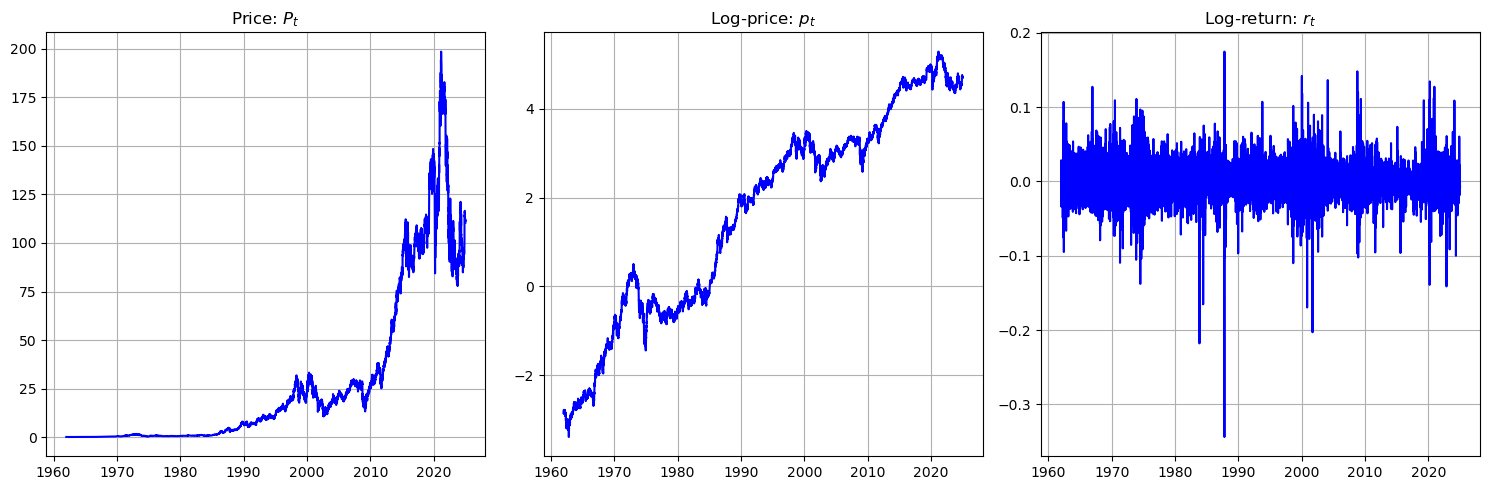

In [54]:
# Create a plot summary of the prices and returns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Daily prices
axs[0].plot(Pt_daily.index, Pt_daily, color='blue')
axs[0].set_title('Price: $P_t$')
axs[0].grid(True)
# Daily log prices
axs[1].plot(pt_daily.index, pt_daily, color='blue')
axs[1].set_title('Log-price: $p_t$')
axs[1].grid(True)
# Daily log-returns
axs[2].plot(rt_daily.index, rt_daily, color='blue')
axs[2].set_title('Log-return: $r_t$')
axs[2].grid(True)

# Adjust layout and plot
plt.tight_layout()
plt.show()

In [55]:
# Add descriptive table

# Define log returns sources
rt = {
    "Daily": rt_daily,
    "Weekly": rt_weekly,
    "Monthly": rt_monthly,
    "Annual": rt_yearly
}

# Create statistics computation function
def statistics(x):
    stat_tab = {
        'Mean': round(np.mean(x) * 100,5),
        'St.Deviation': round(np.std(x) * 100,5),
        'Diameter.C.I.Mean': round(1.96 * np.sqrt(np.var(x) / len(x)) * 100,5),
        'Skewness': round(skew(x),5),
        'Kurtosis': round(kurtosis(x),5),
        'Excess.Kurtosis': round(kurtosis(x) - 3,5),
        'Min': round(np.min(x) * 100,5),
        'Quant.5%': round(np.quantile(x, 0.05) * 100,5),
        'Quant.25%': round(np.quantile(x, 0.25) * 100,5),
        'Median': round(np.quantile(x, 0.50) * 100,5),
        'Quant.75%': round(np.quantile(x, 0.75) * 100,5),
        'Quant.95%': round(np.quantile(x, 0.95) * 100,5),
        'Max': round(np.max(x) * 100,5),
        'Jarque.Bera.stat': round(jarque_bera(x)[0],5),
        'Jarque.Bera.pvalue.X100': round(jarque_bera(x)[1] *100,5),
        'Lillie.test.stat': round(lilliefors(x)[0],5),
        'Lillie.test.pvalue.X100': round(lilliefors(x)[1] * 100,5),
        'N.obs': len(x)
    }
    return stat_tab

STATS = pd.DataFrame({key: statistics(data) for key, data in rt.items()})

STATS

,Daily,Weekly,Monthly,Annual
Mean,0.04768,0.22978,1.00899,12.43498
St.Deviation,1.98466,4.24503,8.89996,31.37347
Diameter.C.I.Mean,0.03089,0.14515,0.63527,7.87324
Skewness,-0.38827,-0.24040,-0.46561,-0.81501
Kurtosis,12.31760,3.18203,2.67321,1.79340
Excess.Kurtosis,9.31760,0.18203,-0.32679,-1.20660
Min,-34.38208,-27.72753,-47.67278,-91.84053
Quant.5%,-2.90383,-6.20485,-13.41768,-33.76457
Quant.25%,-0.96001,-2.14481,-3.94160,-0.38745
Median,0.00000,0.18661,1.37337,13.28352


#### Stylized Fact 1: Prices are non-stationary

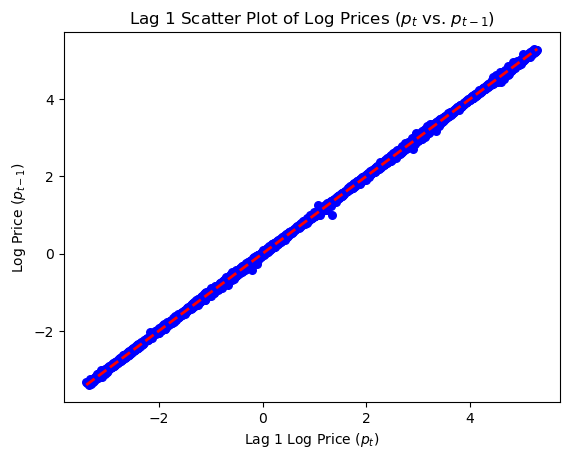

In [56]:
# TEST 1: Lag-1 scatter plot of log-returns

# Define lagged time series
pt_daily_lag1 = pt_daily.shift(1)

# Define the lag1_scatterplot function
plt.scatter(pt_daily_lag1, pt_daily, color='blue', s=30)
plt.plot([min(pt_daily), max(pt_daily)], [min(pt_daily), max(pt_daily)], linestyle='dashed', linewidth=2, color='red') 
plt.xlabel("Lag 1 Log Price ($p_t$)")
plt.ylabel("Log Price ($p_{t-1}$)")
plt.title("Lag 1 Scatter Plot of Log Prices ($p_t$ vs. $p_{t-1}$)")
plt.show()

In [57]:
# TEST 2: Augmented Dickey-Fuller (ADF) test

# Test results
adf_result = adfuller(pt_daily)
ADF = pd.Series({
    "ADF": adf_result[0],
    "p-value": adf_result[1],
    "Critical Value (1%)": adf_result[4]['1%'],
    "Critical Value (5%)": adf_result[4]['5%'],
    "Critical Value (10%)": adf_result[4]['10%']
})

print(f"H0: δ = 0 (unit root, non-stationary)\nH1: δ < 0 (no unit root, stationary)\n-----\n{ADF}\n-----")

if ADF["p-value"] > 0.05 and ADF["ADF"] > ADF["Critical Value (10%)"]:
    print("Fail to reject the null hypothesis, the time series is likely non-stationary.")
else : 
    print("Reject the null hypothesis, the time series is likely stationary.")

H0: δ = 0 (unit root, non-stationary)
H1: δ < 0 (no unit root, stationary)
-----
ADF                    -1.477324
p-value                 0.544698
Critical Value (1%)    -3.430763
Critical Value (5%)    -2.861722
Critical Value (10%)   -2.566867
dtype: float64
-----
Fail to reject the null hypothesis, the time series is likely non-stationary.


In [58]:
# TEST 3: Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

kpss_results = kpss(pt_daily, regression='c')
print(kpss_results)

KPSS = pd.Series({
    "KPSS": kpss_results[0],
    "p-value": kpss_results[1],
    "Critical Value (1%)": kpss_results[3]['1%'],
    "Critical Value (5%)": kpss_results[3]['5%'],
    "Critical Value (10%)": kpss_results[3]['10%']
})

print(f"H0: Var(u) = 0 (no white noise, stationary)\nH1: Var(u) > 0 (white noise, non stationary)\n-----\n{KPSS}\n-----")

if KPSS["p-value"] > 0.05 and KPSS["KPSS"] < KPSS["Critical Value (10%)"]:
    print("Fail to reject the null hypothesis, the time series is likely stationary.")
else : 
    print("Reject the null hypothesis, the time series is likely non-stationary.")

(np.float64(19.958249551532706), np.float64(0.01), 75, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
H0: Var(u) = 0 (no white noise, stationary)
H1: Var(u) > 0 (white noise, non stationary)
-----
KPSS                    19.95825
p-value                  0.01000
Critical Value (1%)      0.73900
Critical Value (5%)      0.46300
Critical Value (10%)     0.34700
dtype: float64
-----
Reject the null hypothesis, the time series is likely non-stationary.


/var/folders/z6/j_nqb41d7p71wfmbz0m97p200000gn/T/ipykernel_5046/164833884.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_results = kpss(pt_daily, regression='c')


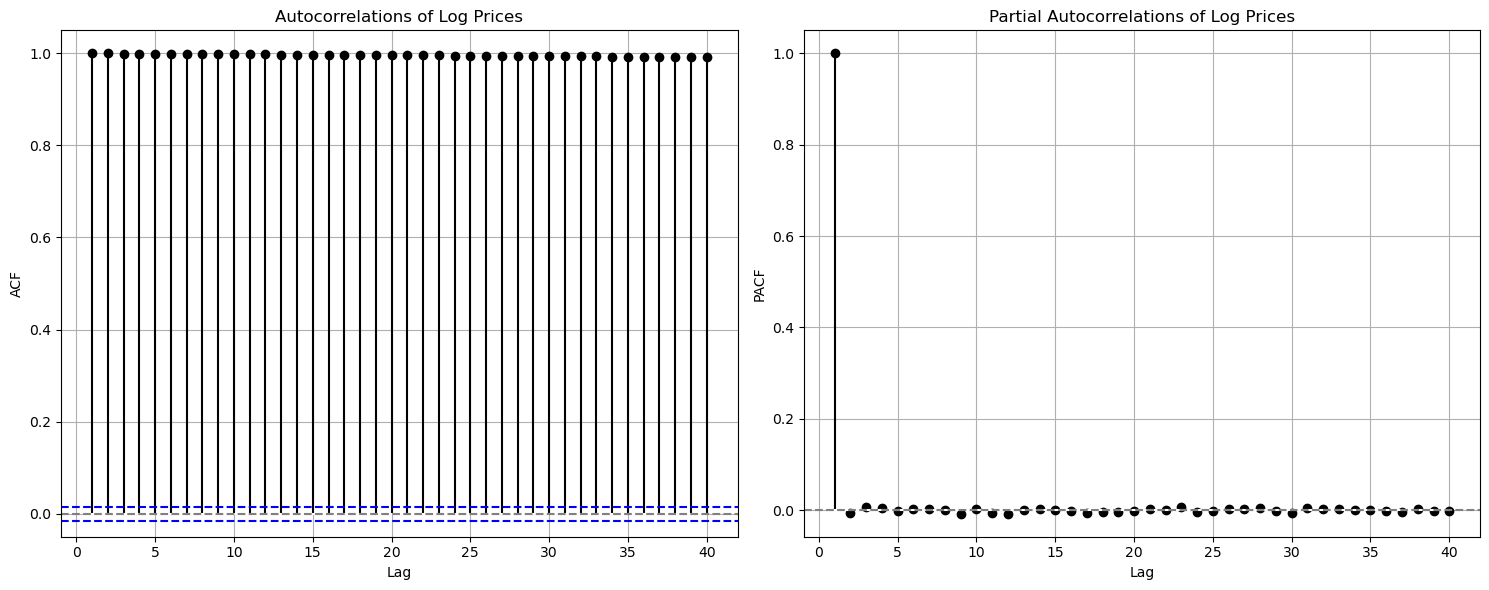

In [59]:
# TEST 4: Autocorrelation function and Partial Autocorrelation Function
lags = 40
conf_value = 1.96
acf_values = acf(pt_daily, nlags=lags)
pacf_values = pacf(pt_daily, nlags=lags)

#Bartlett intervals for ACF
bartlett = conf_value / np.sqrt(len(pt_daily))

fig, axs = plt.subplots(1, 2, figsize=(15, 6)) 

# ACF (Autocorrelation Function)
axs[0].stem(np.arange(1, lags + 1), acf_values[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[0].axhline(y=0, color='gray', linestyle='--')
axs[0].axhline(y=bartlett, color='blue', linestyle='--')
axs[0].axhline(y=-bartlett, color='blue', linestyle='--')
axs[0].set_title('Autocorrelations of Log Prices')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')
axs[0].grid(True)

# PACF (Partial Autocorrelation Function)
axs[1].stem(np.arange(1, lags + 1), pacf_values[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[1].axhline(y=0, color='gray', linestyle='--')
axs[1].set_title('Partial Autocorrelations of Log Prices')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF')
axs[1].grid(True)

plt.tight_layout()
plt.show()

#### Stylized Fact 2: Returns are stationary

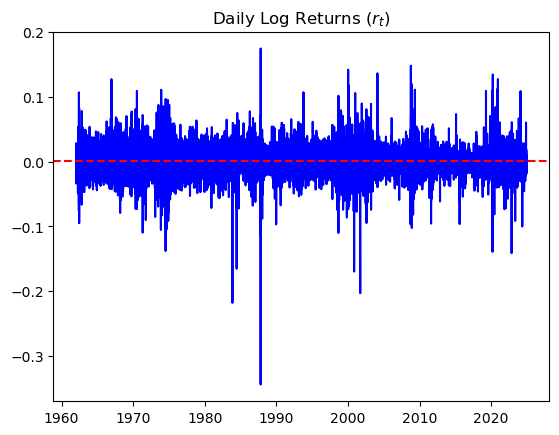

In [60]:
# TEST 1: Lag-1 scatter plot of log-returns

plt.plot(rt_daily, color='blue')
plt.axhline(y=rt_daily.mean(), color="red",linestyle='dashed', linewidth=1.5)
plt.title("Daily Log Returns ($r_t$)")
plt.show()

In [61]:
# TEST 2: Augmented Dickey-Fuller (ADF) test

# Test results
adf_result = adfuller(rt_daily)
ADF = pd.Series({
    "ADF": adf_result[0],
    "p-value": adf_result[1],
    "Critical Value (1%)": adf_result[4]['1%'],
    "Critical Value (5%)": adf_result[4]['5%'],
    "Critical Value (10%)": adf_result[4]['10%']
})

print(f"H0: δ = 0 (unit root, non-stationary)\nH0: δ < 0 (no unit root, stationary)\n-----\n{ADF}\n-----")

if ADF["p-value"] > 0.05 and ADF["ADF"] > ADF["Critical Value (10%)"]:
    print("Fail to reject the null hypothesis, the time series is likely non-stationary.")
else : 
    print("Reject the null hypothesis, the time series is likely stationary.")

H0: δ = 0 (unit root, non-stationary)
H0: δ < 0 (no unit root, stationary)
-----
ADF                    -74.819333
p-value                  0.000000
Critical Value (1%)     -3.430763
Critical Value (5%)     -2.861722
Critical Value (10%)    -2.566867
dtype: float64
-----
Reject the null hypothesis, the time series is likely stationary.


In [62]:
# TEST 3: Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

kpss_results = kpss(rt_daily, regression='c')
print(kpss_results)

KPSS = pd.Series({
    "KPSS": kpss_results[0],
    "p-value": kpss_results[1],
    "Critical Value (1%)": kpss_results[3]['1%'],
    "Critical Value (5%)": kpss_results[3]['5%'],
    "Critical Value (10%)": kpss_results[3]['10%']
})

print(f"H0: Var(u) = 0 (no white noise, stationary)\nH1: Var(u) > 0 (white noise, non stationary)\n-----\n{KPSS}\n-----")

if KPSS["p-value"] > 0.05 and KPSS["KPSS"] < KPSS["Critical Value (10%)"]:
    print("Fail to reject the null hypothesis, the time series is likely stationary.")
else : 
    print("Reject the null hypothesis, the time series is likely non-stationary.")

(np.float64(0.12996456642391976), np.float64(0.1), 0, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
H0: Var(u) = 0 (no white noise, stationary)
H1: Var(u) > 0 (white noise, non stationary)
-----
KPSS                    0.129965
p-value                 0.100000
Critical Value (1%)     0.739000
Critical Value (5%)     0.463000
Critical Value (10%)    0.347000
dtype: float64
-----
Fail to reject the null hypothesis, the time series is likely stationary.


/var/folders/z6/j_nqb41d7p71wfmbz0m97p200000gn/T/ipykernel_5046/3665203255.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_results = kpss(rt_daily, regression='c')


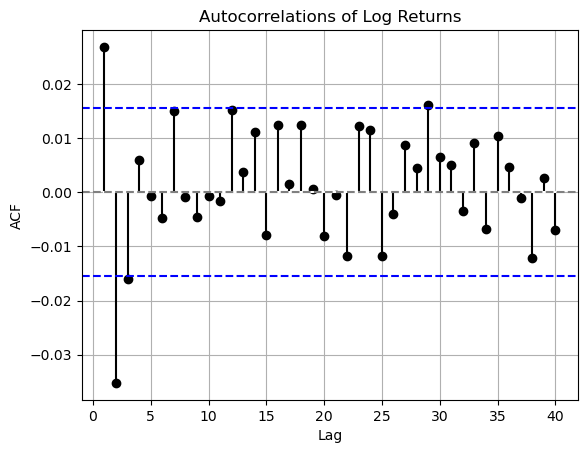

In [63]:
# TEST 4: Autocorrelation function
lags = 40
conf_value = 1.96
acf_values = acf(rt_daily, nlags=lags)

#Bartlett intervals for ACF
bartlett = conf_value / np.sqrt(len(rt_daily))

# ACF (Autocorrelation Function)
plt.stem(np.arange(1, lags + 1), acf_values[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
plt.axhline(y=0, color='gray', linestyle='--')
plt.axhline(y=bartlett, color='blue', linestyle='--')
plt.axhline(y=-bartlett, color='blue', linestyle='--')
plt.title('Autocorrelations of Log Returns')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)

plt.show()

#### Stylized Fact 3: Returns are asymmetric (negative skewness)


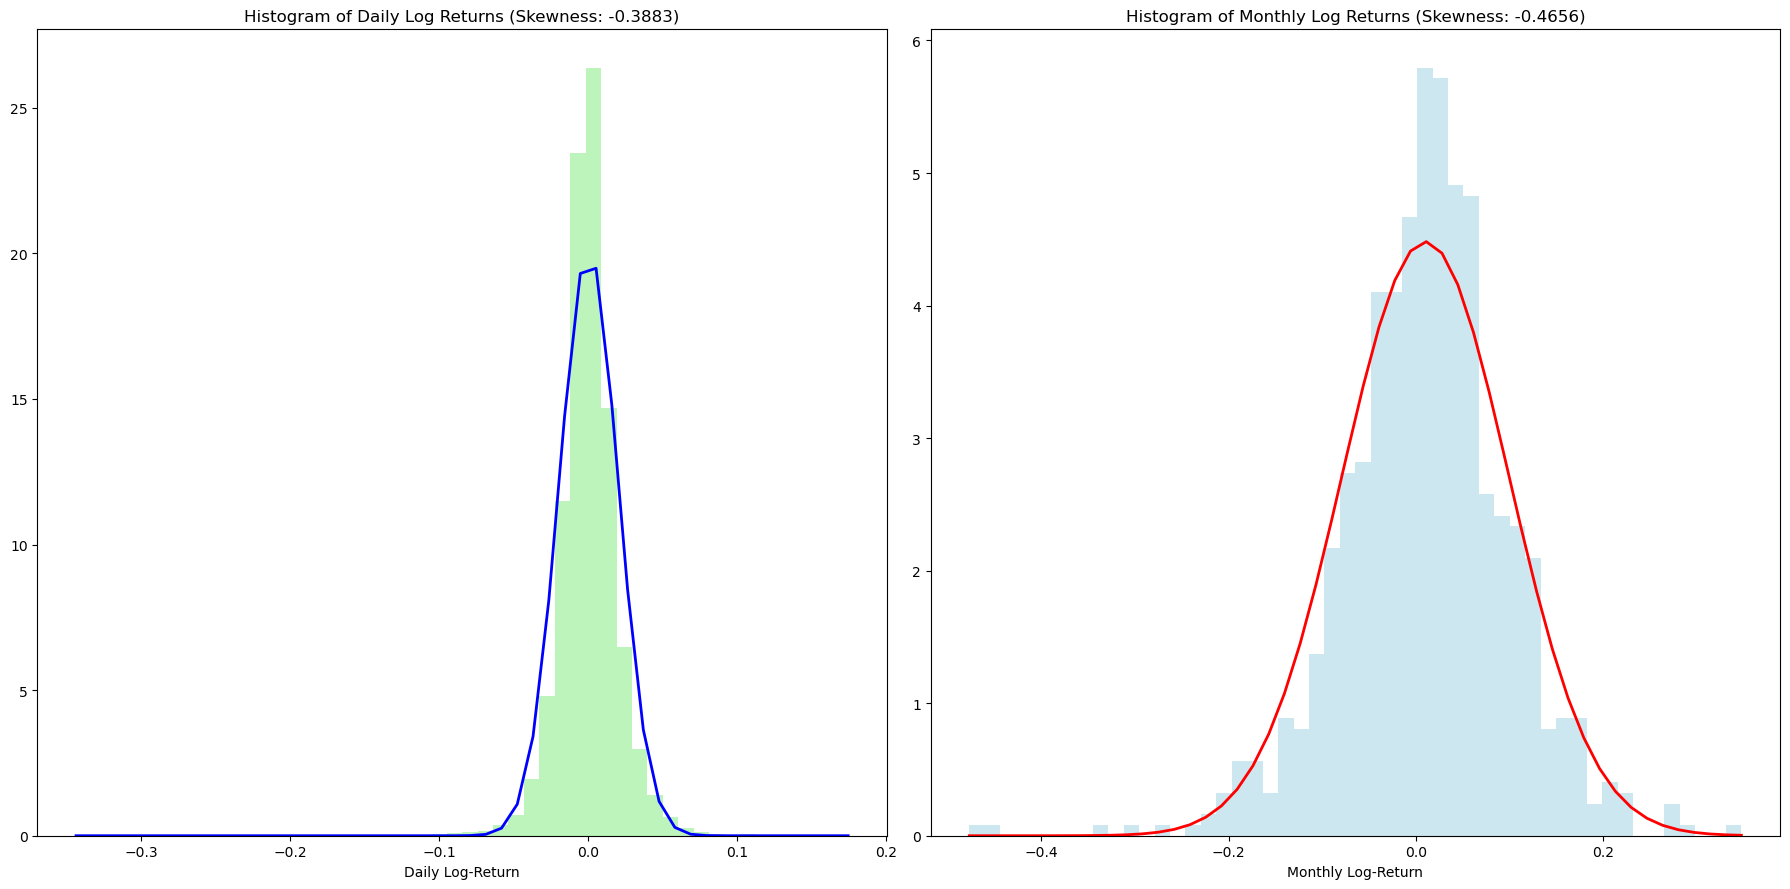

Daily log returns skewness: -0.38826898350454936
Monthly log returns skewness: -0.46561090276986383


In [64]:
# TEST 1: Histogram and skewness versus normal distribution

# Skewness computation
skew_daily = skew(rt_daily) ### REMPLACER PAR la valeur calculé dans le tableau descriptif
skew_monthly = skew(rt_monthly) ### REMPLACER PAR la valeur calculé dans le tableau descriptif

# Theoretical normal distributions
normal_daily = stats.norm.pdf(np.linspace(rt_daily.min(),rt_daily.max()), loc=np.mean(rt_daily), scale=np.std(rt_daily))
normal_monthly = stats.norm.pdf(np.linspace(rt_monthly.min(),rt_monthly.max()), loc=np.mean(rt_monthly),scale=np.std(rt_monthly))

# Plotting histogram and normal distribution
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

axs[0].hist(rt_daily, bins=50, density=True, color="lightgreen",alpha=0.6)
axs[0].plot(np.linspace(rt_daily.min(), rt_daily.max()),normal_daily, color="blue", linewidth=2)
axs[0].set_xlabel("Daily Log-Return")
axs[0].set_title(f"Histogram of Daily Log Returns (Skewness: {skew_daily:.4f})")

axs[1].hist(rt_monthly, bins=50, density=True, color="lightblue",alpha=0.6)
axs[1].plot(np.linspace(rt_monthly.min(), rt_monthly.max()),normal_monthly, color="red", linewidth=2)
axs[1].set_xlabel("Monthly Log-Return")
axs[1].set_title(f"Histogram of Monthly Log Returns (Skewness: {skew_monthly:.4f})")

plt.tight_layout()
plt.show()

print(f"Daily log returns skewness: {skew_daily}\nMonthly log returns skewness: {skew_monthly}")

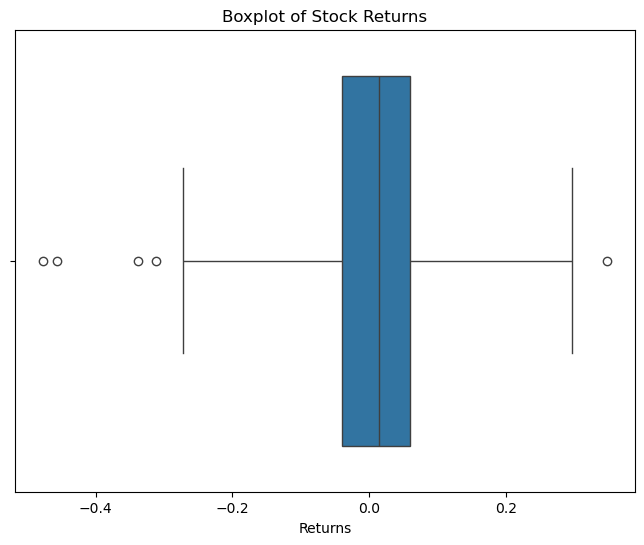

Median relative to mean of daily log returns: -0.0036437229718824203


In [65]:
# Test 2: Boxplot and median

excess_median = rt_monthly.mean() - rt_monthly.median() # REMPLACER PAR VALEUR DU TABLEAU

plt.figure(figsize=(8, 6))
sns.boxplot(x=rt_monthly,whis=2.5)
plt.title('Boxplot of Stock Returns')
plt.xlabel('Returns')
plt.show()

print(f'Median relative to mean of daily log returns: {excess_median}')

In [66]:
# Test 3: Jarque-Bera test

# Jarque-Bera test to check for skewness and kurtosis
jarque_bera_results = stats.jarque_bera(rt_monthly)
JB = pd.Series({
    "JB": round(jarque_bera_results[0], 4),
    "p-value": jarque_bera_results[1]
})

print(f"H0: Skew = 0 and Kurt = 3 (normality of skewness and tails)\nH1: Skew ≠ 0 and/or Kurt ≠ 3 (non-normality of skewness and tails)\n-----\n{JB}\n-----")

if JB["p-value"] > 0.05:
    print("Fail to reject the null hypothesis, the returns skewness and tails are not significantly different from those of a normal distribution.")
else : 
    print("Reject the null hypothesis, the returns skewness and/or tails are significantly different from those of a normal distribution.")

H0: Skew = 0 and Kurt = 3 (normality of skewness and tails)
H1: Skew ≠ 0 and/or Kurt ≠ 3 (non-normality of skewness and tails)
-----
JB         2.517487e+02
p-value    2.155117e-55
dtype: float64
-----
Reject the null hypothesis, the returns skewness and/or tails are significantly different from those of a normal distribution.


In [67]:
# TEST 4: D'Agostino normal skewness test (1970)

# D'Agostino test with H1 being excplicitly negative skewness
agostino_result = stats.skewtest(rt_monthly, alternative='less')
AGST = pd.Series({
    "AGST": agostino_result[0],
    "p-value": agostino_result[1]
})

print(f"H0: Skew = 0 (normality of skewness)\nH1: Skew < 0 (negative skewness, non-normality)\n-----\n{AGST}\n-----")

if AGST["p-value"] > 0.05:
    print("Fail to reject the null hypothesis, the returns skewness is not significantly different from a normal distribution.")
else : 
    print("Reject the null hypothesis, the returns skewness is negative and is significantly different from a normal distribution.")

H0: Skew = 0 (normality of skewness)
H1: Skew < 0 (negative skewness, non-normality)
-----
AGST      -5.026233e+00
p-value    2.501037e-07
dtype: float64
-----
Reject the null hypothesis, the returns skewness is negative and is significantly different from a normal distribution.


#### Stylized Fact 4: Returns have heavy tails

In [68]:
# TEST 1: Kurtosis of log returns (4th centralized standardized moment)

kurt_daily = kurtosis(rt_daily, nan_policy='omit')
kurt_weekly = kurtosis(rt_weekly, nan_policy='omit')
kurt_monthly = kurtosis(rt_monthly, nan_policy='omit')
kurt_yearly = kurtosis(rt_yearly, nan_policy='omit')

def describe_kurt(kurtosis):
    return (
        "Heavy tails (leptokurtic)" if kurtosis > 3 else
        "Light tails (platokurtic)" if kurtosis < 3 else
        "Normal distribution tails (mesokurtic)"
    )

print("Kurtosis of log returns\n-----")
print(f"Daily: {kurt_daily} → {describe_kurt(kurt_daily)}")
print(f"Weekly: {kurt_weekly} → {describe_kurt(kurt_weekly)}")
print(f"Monthly: {kurt_monthly} → {describe_kurt(kurt_monthly)}")
print(f"Annual: {kurt_yearly} → {describe_kurt(kurt_yearly)}")


"""Results indicates the impact of 'Theorem on Aggregation of iid returns' (p.157 lecture), see LLN/CLT.
 'Les log-returns sont leptokurtiques à haute fréquence (daily/weekly), mais l’agrégation temporelle réduit la lourdeur des queues.' """

Kurtosis of log returns
-----
Daily: 12.31760125166973 → Heavy tails (leptokurtic)
Weekly: 3.182029000997039 → Heavy tails (leptokurtic)
Monthly: 2.67320897199537 → Light tails (platokurtic)
Annual: 1.7934000344884575 → Light tails (platokurtic)


"Results indicates the impact of 'Theorem on Aggregation of iid returns' (p.157 lecture), see LLN/CLT.\n 'Les log-returns sont leptokurtiques à haute fréquence (daily/weekly), mais l’agrégation temporelle réduit la lourdeur des queues.' "

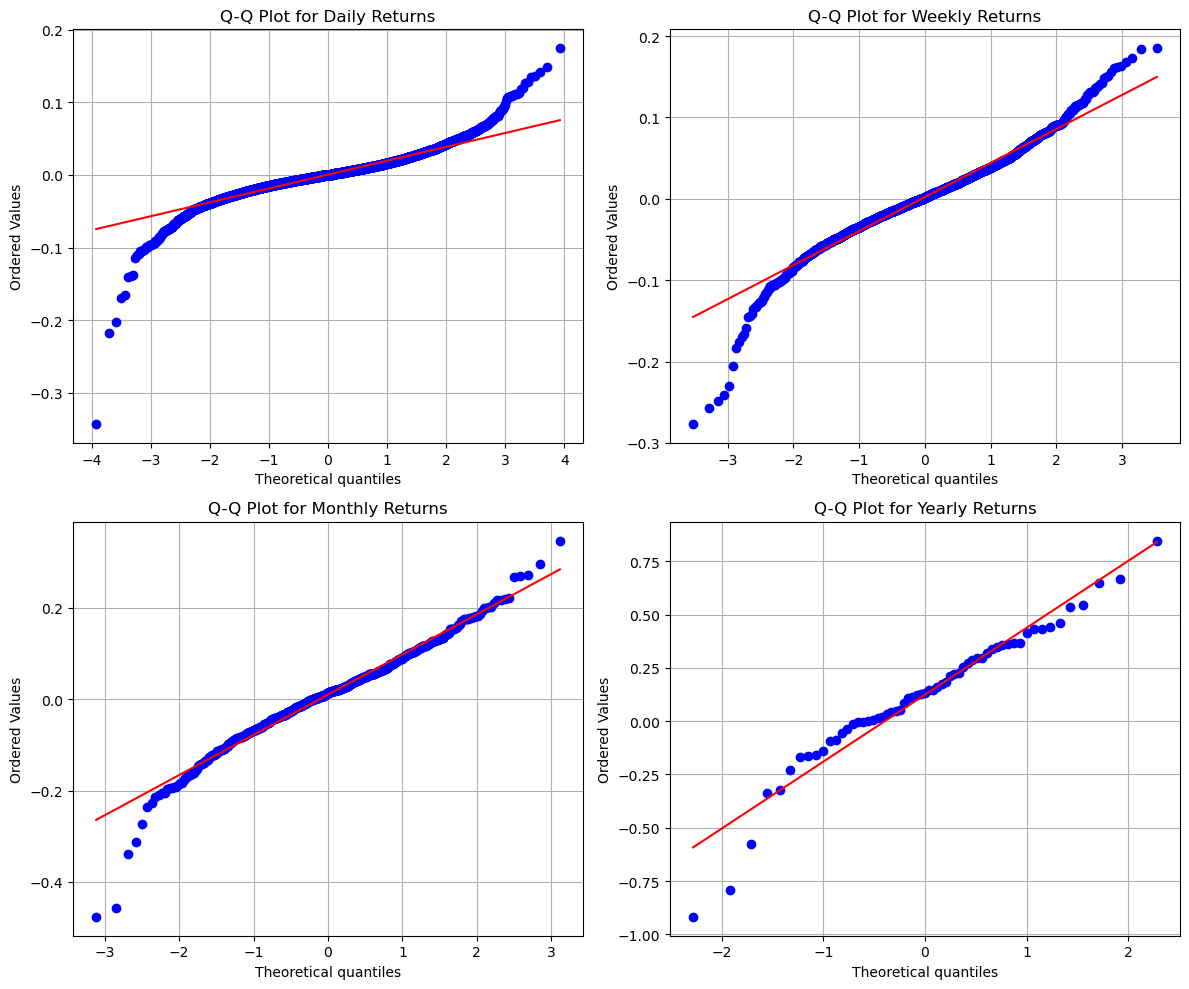

In [69]:
# TEST 2: Q-Q Plot of Log Returns

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

stats.probplot(rt_daily, dist="norm", plot=axs[0, 0])
axs[0, 0].set_title("Q-Q Plot for Daily Returns")
axs[0, 0].grid(True)

stats.probplot(rt_weekly, dist="norm", plot=axs[0, 1])
axs[0, 1].set_title("Q-Q Plot for Weekly Returns")
axs[0, 1].grid(True)

stats.probplot(rt_monthly, dist="norm", plot=axs[1, 0])
axs[1, 0].set_title("Q-Q Plot for Monthly Returns")
axs[1, 0].grid(True)

stats.probplot(rt_yearly, dist="norm", plot=axs[1, 1])
axs[1, 1].set_title("Q-Q Plot for Yearly Returns")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [70]:
# TEST 3: Hill Estimator (Pareto) of 5% daily and weekly returns (not relevant on weekly and monthly)

# Tail quantile
tail_quantile = 0.95

# Daily absolute log returns
pos_rt_daily = rt_daily[rt_daily > 0]
neg_rt_daily = np.abs(rt_daily[rt_daily < 0])
right_tail_daily = pwl.Fit(pos_rt_daily, xmin=np.quantile(pos_rt_daily, tail_quantile))
left_tail_daily = pwl.Fit(neg_rt_daily, xmin=np.quantile(neg_rt_daily, tail_quantile))

# Weekly absolute log returns
pos_rt_weekly = rt_weekly[rt_weekly > 0]
neg_rt_weekly = np.abs(rt_weekly[rt_weekly < 0])
right_tail_weekly = pwl.Fit(pos_rt_weekly, xmin=np.quantile(pos_rt_weekly, tail_quantile))
left_tail_weekly = pwl.Fit(neg_rt_weekly, xmin=np.quantile(neg_rt_weekly, tail_quantile))

HILL = pd.DataFrame({
    "Daily": [left_tail_daily.alpha, right_tail_daily.alpha],
    "Weekly": [left_tail_weekly.alpha, right_tail_weekly.alpha],
}, index= ["Left.Alpha", "Right.Alpha"])


print(f"Hill test for daily and weekly log returns:\n-----\n{HILL}\n-----")
print(f"The left tail of daily log returns is {"heavier" if left_tail_daily.alpha > right_tail_daily.alpha else "lighter"} than the right tail")
print(f"The left tail of weekly log returns is {"heavier" if left_tail_weekly.alpha > right_tail_weekly.alpha else "lighter"} than the right tail")

Hill test for daily and weekly log returns:
-----
                Daily    Weekly
Left.Alpha   4.077892  4.186701
Right.Alpha  4.512699  5.288614
-----
The left tail of daily log returns is lighter than the right tail
The left tail of weekly log returns is lighter than the right tail


In [71]:
"""
Note on the interpretation of Hill vs Kurtosis:
The Hill estimator is specifically designed to quantify the “heaviness” of the tail of a distribution. 
Unlike kurtosis, which looks at all data points, the Hill focuses only on the largest observations (or smallest for the left tail), i.e., the extreme events.

Kurtosis is very sensitive to outliers (4th order), Hill describes the general shape of tails.
Hill quantifies the tail thickness, i.e., the general likelihood of observing extreme events.
It does not spike for a single extreme outlier, unlike kurtosis which can be strongly influenced by a single extreme.
Kurtosis is more descriptive, good for stylized facts, but does not differentiate moderate vs. extreme tails as precisely as Hill.

In our case:
The results show that tails differ from normal distribution tails, but moderately, and mainly due to extreme outliers.
A normal distribution has alpha = approx 7.
"""

'\nNote on the interpretation of Hill vs Kurtosis:\nThe Hill estimator is specifically designed to quantify the “heaviness” of the tail of a distribution. \nUnlike kurtosis, which looks at all data points, the Hill focuses only on the largest observations (or smallest for the left tail), i.e., the extreme events.\n\nKurtosis is very sensitive to outliers (4th order), Hill describes the general shape of tails.\nHill quantifies the tail thickness, i.e., the general likelihood of observing extreme events.\nIt does not spike for a single extreme outlier, unlike kurtosis which can be strongly influenced by a single extreme.\nKurtosis is more descriptive, good for stylized facts, but does not differentiate moderate vs. extreme tails as precisely as Hill.\n\nIn our case:\nThe results show that tails differ from normal distribution tails, but moderately, and mainly due to extreme outliers.\nA normal distribution has alpha = approx 7.\n'

#### Stylized facts 5: Aggregational Gaussianity

In [72]:
"""
The non gaussianity of high frequency TS is already proven by the skewness and kurtosis test which reject the hypothesis.
These two test gives hint about the gaussianity of low freq TS (see kurtosis, or skew).
QQ plot also gives hint about this.
"""

'\nThe non gaussianity of high frequency TS is already proven by the skewness and kurtosis test which reject the hypothesis.\nThese two test gives hint about the gaussianity of low freq TS (see kurtosis, or skew).\nQQ plot also gives hint about this.\n'

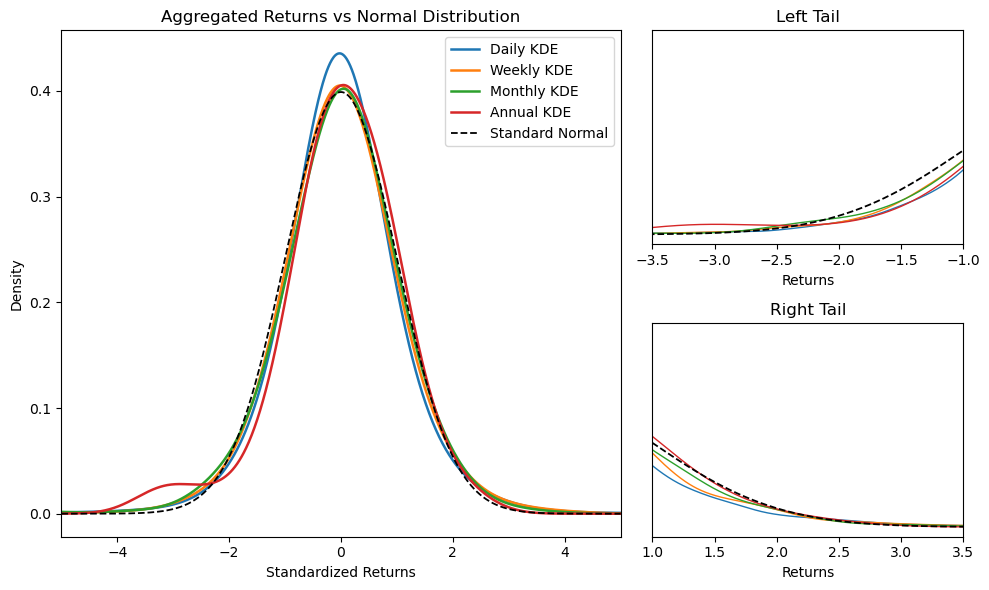

In [73]:
# TEST 1: Trouver le bon plot:

# Idée : les 3 KDE standardized vs standard normal, avec zoom partie gauche et droite pour voir la différence entre chaque
# Faire une standardisation de chaque pour obtenir le bon cdf a la même échelle

# Create a dictionnary of standardized time series
rt_std = {
    "Daily": (rt_daily - np.mean(rt_daily)) / np.std(rt_daily),
    "Weekly": (rt_weekly - np.mean(rt_weekly)) / np.std(rt_weekly),
    "Monthly": (rt_monthly - np.mean(rt_monthly)) / np.std(rt_monthly),
    "Annual": (rt_yearly - np.mean(rt_yearly)) / np.std(rt_yearly)
}

# Support of X
x = np.linspace(-5, 5, 1000)
normal_pdf = norm.pdf(x)

# Plot configuration
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[1.8, 1], height_ratios=[1, 1])
axs = [
    fig.add_subplot(gs[:, 0]),   # grand plot à gauche
    fig.add_subplot(gs[0, 1]),   # zoom sur left tail
    fig.add_subplot(gs[1, 1])    # zoom sur right tail
]

# Define colors for visual clarity
colors = {
    "Daily": "#E74C3C",   # rouge vif
    "Weekly": "#E67E22",  # orange
    "Monthly": "#F1C40F", # jaune doré
    "Annual": "#2ECC71"   # vert clair
}

# Global view of kernel vs normal
for label, data in rt_std.items():
    kde = gaussian_kde(data, bw_method=0.5)
    axs[0].plot(x, kde(x), label=f'{label} KDE', lw=1.8)
axs[0].plot(x, normal_pdf, color='black', linestyle='--', lw=1.3, label='Standard Normal')
axs[0].set_title('Aggregated Returns vs Normal Distribution')
axs[0].legend()
axs[0].set_xlim(-5, 5)
axs[0].set_xlabel('Standardized Returns')
axs[0].set_ylabel('Density')

# Zoom plot to better capture the spread
zoom_ranges = [(-3.5, -1), (1, 3.5)]
zoom_titles = ['Left Tail', 'Right Tail']

for ax, (xlim, title) in zip(axs[1:], zip(zoom_ranges, zoom_titles)):
    for label, data in rt_std.items():
        kde = gaussian_kde(data)
        ax.plot(x, kde(x), lw=1)
    ax.plot(x, normal_pdf, color='black', linestyle='--', lw=1.3)
    ax.set_xlim(*xlim)
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xlabel('Returns')


plt.tight_layout()
plt.show()

In [74]:
"""
the Shapiro-Wilk test is highly sensitive to tail behavior, the
Anderson-Darling places more weight on the tails, and the Lilliefors test adapts Kolmogorov-Smirnov
specifically for normality.
We choose daily, weekly, and monthly, since annually as not enough values
"""

'\nthe Shapiro-Wilk test is highly sensitive to tail behavior, the\nAnderson-Darling places more weight on the tails, and the Lilliefors test adapts Kolmogorov-Smirnov\nspecifically for normality.\nWe choose daily, weekly, and monthly, since annually as not enough values\n'

In [75]:
# TEST 2: Lilliefors test on log returns

# Perform Lilliefors test for all frequencies
lilli_results = {freq: lilliefors(data) for freq, data in rt.items()}

# Create a DataFrame from the results
LILF = pd.DataFrame({
        "Statistic": [round(result[0], 6) for result in lilli_results.values()],
        "p-value": [round(result[1], 6) for result in lilli_results.values()]
    }, index= lilli_results.keys()).transpose()

def describe_lilli(x):
    return (
        f"Fail to reject the null hypothesis, the time series doesn't differ significantly from a normal distribution"
        if x > 0.05 else
        f"Reject the null hypothesis, the time series log returns differ significantly from a normal distribution"
    )

# Print results for each frequency
print(f"H0: The time series follow a normal distribution\nH1: The time series doesn't follow a normal distribution\n-----\n{LILF}\n-----")

for freq, (_, p_value) in lilli_results.items():
    print(f"• {freq}: {describe_lilli(p_value)}")

H0: The time series follow a normal distribution
H1: The time series doesn't follow a normal distribution
-----
              Daily    Weekly   Monthly    Annual
Statistic  0.063808  0.041346  0.045682  0.100766
p-value    0.001000  0.001000  0.001000  0.165927
-----
• Daily: Reject the null hypothesis, the time series log returns differ significantly from a normal distribution
• Weekly: Reject the null hypothesis, the time series log returns differ significantly from a normal distribution
• Monthly: Reject the null hypothesis, the time series log returns differ significantly from a normal distribution
• Annual: Fail to reject the null hypothesis, the time series doesn't differ significantly from a normal distribution


In [76]:
# TEST 3: Shapiro-Wilk test on log returns

shapiro_results = {freq: shapiro(data) for freq, data in rt.items()}

# Create a DataFrame from the results
SW = pd.DataFrame({
        "Statistic": [round(result[0], 6) for result in shapiro_results.values()],
        "p-value": [round(result[1], 6) for result in shapiro_results.values()]
    }, index= lilli_results.keys()).transpose()


def describe_shapiro(x):
    return (
        f"Fail to reject the null hypothesis, the time series doesn't differ significantly from a normal distribution"
        if x > 0.05 else
        f"Reject the null hypothesis, the time series log returns differ significantly from a normal distribution"
    )

# Print results for each frequency
print(f"H0: The time series follow a normal distribution\nH1: The time series doesn't follow a normal distribution\n-----\n{SW}\n-----")

for freq, (_, p_value) in shapiro_results.items():
    print(f"• {freq}: {describe_shapiro(p_value)}")

H0: The time series follow a normal distribution
H1: The time series doesn't follow a normal distribution
-----
              Daily    Weekly   Monthly    Annual
Statistic  0.929003  0.970101  0.973647  0.951166
p-value    0.000000  0.000000  0.000000  0.016385
-----
• Daily: Reject the null hypothesis, the time series log returns differ significantly from a normal distribution
• Weekly: Reject the null hypothesis, the time series log returns differ significantly from a normal distribution
• Monthly: Reject the null hypothesis, the time series log returns differ significantly from a normal distribution
• Annual: Reject the null hypothesis, the time series log returns differ significantly from a normal distribution


/opt/anaconda3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15856.
  res = hypotest_fun_out(*samples, **kwds)


In [77]:
"""
Shapiro is extremly sensitive to tail behavior, explaning why the p-value is so low.
With N being high (observations), even small gap have a huge impact
"""

'\nShapiro is extremly sensitive to tail behavior, explaning why the p-value is so low.\nWith N being high (observations), even small gap have a huge impact\n'

In [78]:
# Test 4: Anderson-Darling test on log returns

anderson_results = {freq: anderson(data, dist='norm') for freq, data in rt.items()}

# Create a DataFrame from the results
AD = pd.DataFrame({
        "Statistic": [result.statistic for result in anderson_results.values()],
        "Sig.15%": [result.critical_values[0] for result in anderson_results.values()],
        "Sig.10%": [result.critical_values[1] for result in anderson_results.values()],
        "Sig.5%": [result.critical_values[2] for result in anderson_results.values()],
        "Sig.1%": [result.critical_values[4] for result in anderson_results.values()]
    }, index= lilli_results.keys()).transpose()

def describe_anderson(x, critical_five_p):
    return (
        f"Fail to reject the null hypothesis, the time series doesn't differ significantly from a normal distribution"
        if x < critical_five_p else
        f"Reject the null hypothesis, the time series log returns differ significantly from a normal distribution"
    )

# Print results for each frequency
print(f"H0: The time series follow a normal distribution\nH1: The time series doesn't follow a normal distribution\n-----\n{AD}\n-----")

for freq, (stat, crit_value, _) in anderson_results.items():
    print(f"• {freq}: {describe_anderson(stat, crit_value[2])}")

H0: The time series follow a normal distribution
H1: The time series doesn't follow a normal distribution
-----
                Daily     Weekly   Monthly   Annual
Statistic  168.635135  14.688925  2.981116  0.73175
Sig.15%      0.576000   0.575000  0.573000  0.54400
Sig.10%      0.656000   0.655000  0.653000  0.62000
Sig.5%       0.787000   0.786000  0.783000  0.74300
Sig.1%       1.092000   1.091000  1.086000  1.03100
-----
• Daily: Reject the null hypothesis, the time series log returns differ significantly from a normal distribution
• Weekly: Reject the null hypothesis, the time series log returns differ significantly from a normal distribution
• Monthly: Reject the null hypothesis, the time series log returns differ significantly from a normal distribution
• Annual: Fail to reject the null hypothesis, the time series doesn't differ significantly from a normal distribution


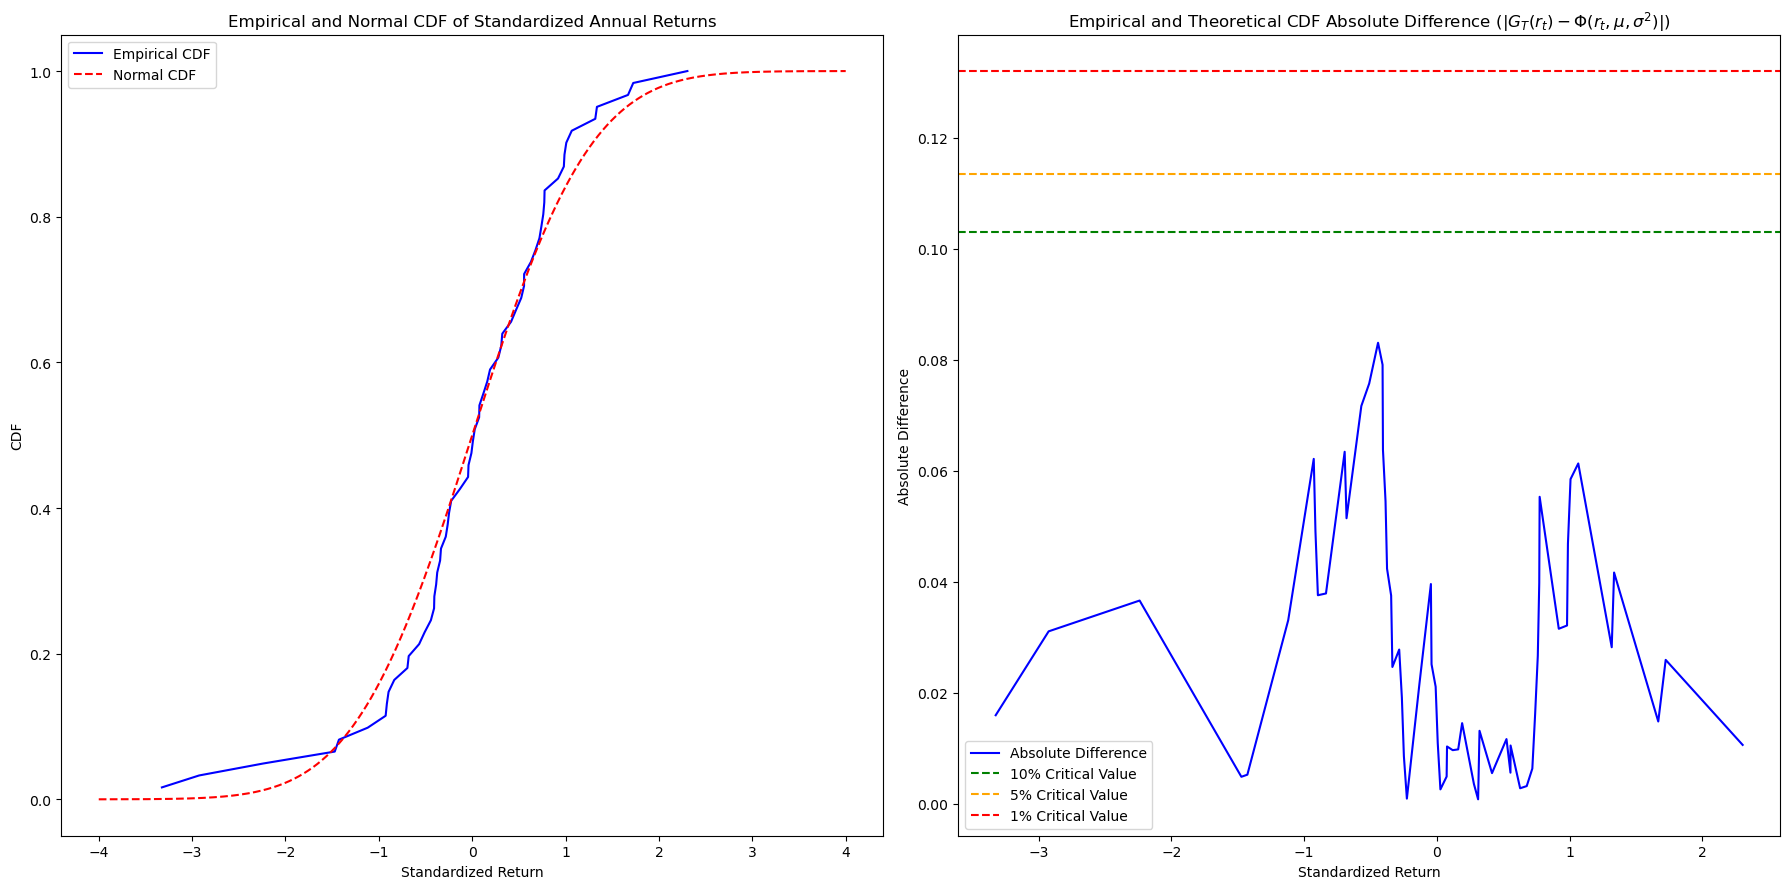

In [79]:
# TEST 5: Empirical CDF and Lillifore graph

# Define the empirical yearly CDF of log returns
rt_yearly_std = rt_std["Annual"]
cdf_values = np.sort(rt_yearly_std)
cdf_empirical = np.arange(1, len(rt_yearly_std)+1) / len(rt_yearly_std)
obs_yearly = len(rt_yearly_std)

# Define the theoritical CDF values 
cdf_normal_values = np.linspace(-4, 4, 1000)
cdf_theoretical_full = stats.norm.cdf(cdf_normal_values)

# Calculate the absolute difference
cdf_theoretical = stats.norm.cdf(cdf_values)
abs_diff = np.abs(cdf_empirical - cdf_theoretical)

# Compute lilifores critical values (from original values)
critical_values = { "10%": 0.805 / np.sqrt(obs_yearly), "5%": 0.886 / np.sqrt(obs_yearly), "1%": 1.031 / np.sqrt(obs_yearly) }

# Plotting histogram and normal distribution
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

# Plot the theoretical vs empirical normal CDF
axs[0].plot(cdf_values, cdf_empirical, label='Empirical CDF', color='blue')
axs[0].plot(cdf_normal_values, cdf_theoretical_full, label='Normal CDF', color='red', linestyle='--')
axs[0].set_title('Empirical and Normal CDF of Standardized Annual Returns')
axs[0].set_xlabel('Standardized Return')
axs[0].set_ylabel('CDF')
axs[0].legend()

# Plot the difference
axs[1].plot(cdf_values, abs_diff, label='Absolute Difference',color='blue')
axs[1].set_title('Empirical and Theoretical CDF Absolute Difference ($|G_T(r_t) - \Phi(r_t, \mu, \sigma^2)|$)')
axs[1].set_xlabel('Standardized Return')
axs[1].set_ylabel('Absolute Difference')

# Plot Lilliefors critical values ()
axs[1].axhline(y=critical_values["10%"], label='10% Critical Value', linestyle='--', color='green')
axs[1].axhline(y=critical_values["5%"], label='5% Critical Value', linestyle='--', color='orange')
axs[1].axhline(y=critical_values["1%"], label='1% Critical Value', linestyle='--', color='red')
axs[1].legend()

plt.tight_layout()
plt.show()

#### Stylized Fact 6: Returns are not autocorrelated

In [80]:
"""
Note that no correlation doesn't mean independance, but independance mean correlation
"""

"\nNote that no correlation doesn't mean independance, but independance mean correlation\n"

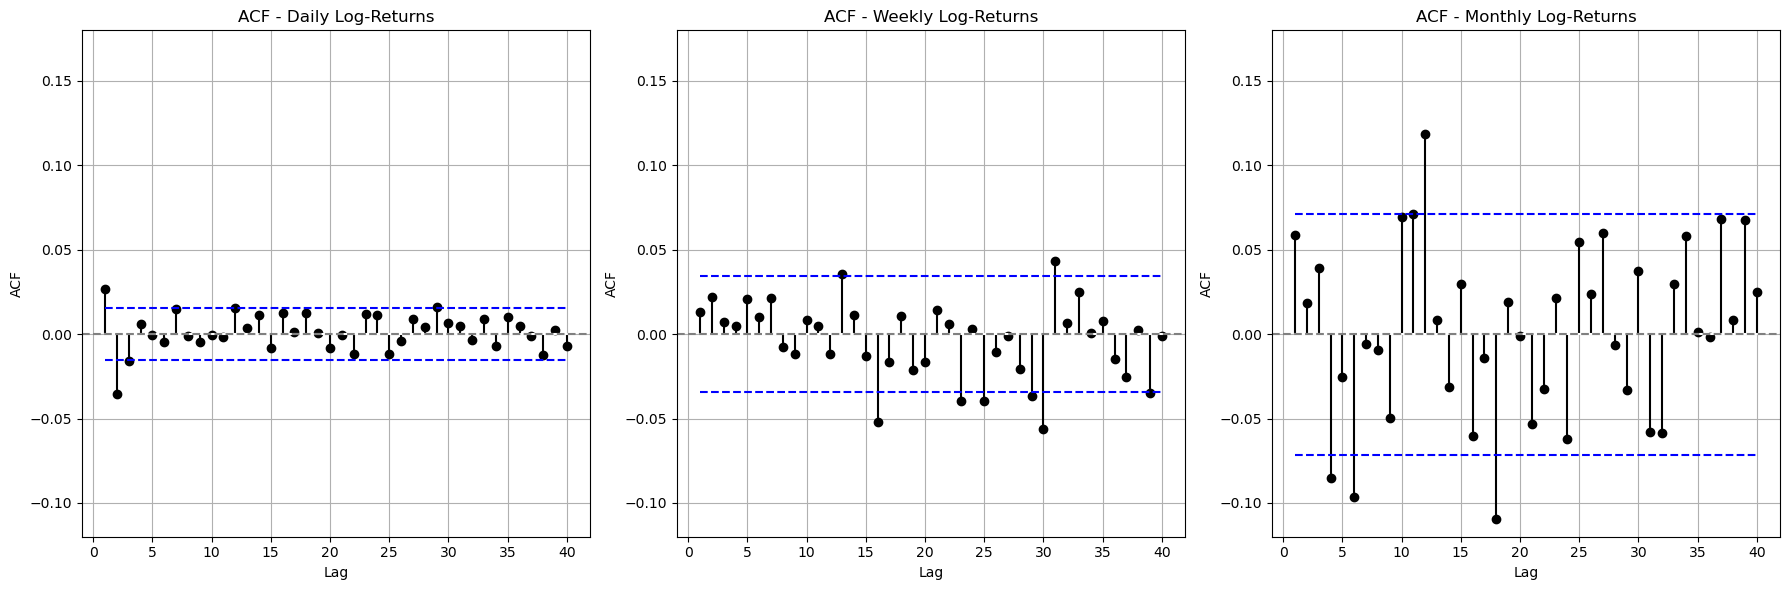

Autocorrelation function
-----
               Daily    Weekly   Monthly
Interval    0.015565  0.034192  0.071379
Violations  4.000000  8.000000  4.000000
-----
• Significant autocorrelation of daily returns at lags: 1, 2, 3, 29
• Significant autocorrelation of weekly returns at lags: 13, 16, 23, 25, 29, 30, 31, 39
• Significant autocorrelation of monthly returns at lags: 4, 6, 12, 18


In [81]:
# TEST 1: ACF plotting

# Define function setting
lags = 40
valueint = 1.96

# Define the DataFrame structure
agg_acf = {}

# Create a subplot to plot ACF
fig, axs = plt.subplots(1, len(rt) - 1, figsize=(18, 6))  # len(rt) - 1 pour exclure "Annual"

# Plot and create data structure
for i, (freq, data) in enumerate(rt.items()):
    if freq == "Annual":
        continue  

    # Compute ACF values
    acf_values = acf(data, nlags=lags)
    confint = valueint / np.sqrt(len(data))
    confint_upper = np.full(lags, confint)
    confint_lower = -np.full(lags, confint)

    # Detect interval violation
    acf_lags = acf_values[1:]
    violations = np.where((acf_lags > confint) | (acf_lags < -confint))[0] + 1
    n_viol = len(violations)
    violidx = ", ".join(map(str, violations)) if n_viol > 0 else None
    agg_acf[freq] = [confint, n_viol, violidx]


    # Plot the result
    axs[i].stem(np.arange(1, lags + 1), acf_values[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
    axs[i].axhline(y=0, color='gray', linestyle='--')
    axs[i].plot(np.arange(1, lags + 1), confint_upper, color='blue', linestyle='dashed')
    axs[i].plot(np.arange(1, lags + 1), confint_lower, color='blue', linestyle='dashed')
    axs[i].set_ylim(-0.12, 0.18)
    axs[i].set_title(f'ACF - {freq} Log-Returns')
    axs[i].set_xlabel('Lag')
    axs[i].set_ylabel('ACF')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# Create a summary data frame
ACFT = pd.DataFrame({key: value[:-1] for key, value in agg_acf.items() if value},index=['Interval', "Violations"])

# Print table and results for each frequency
print(f"Autocorrelation function\n-----\n{ACFT}\n-----")
for freq, (_, _, idx) in agg_acf.items():
    print(f"• Significant autocorrelation of {freq.lower()} returns at lags: {idx}")

In [82]:
# TEST 2 : Ljung-Box and Box-Pierce tests for autocorrelation

# Define the lag to test for
lag_lj = 25
valueint = 1.96
LBBP = {}

# Compute LB and BP tests on daily, weekly, and monthly returns
for freq, series in rt.items():
    if freq == "Annual":
        continue
    
    # Compute the Ljung-Box and Box-Pierce test
    lbbp_results = acorr_ljungbox(series, lags=np.arange(1, lag_lj+1), boxpierce=True)

    # Compute ACF test and critical value for daily returns
    acf_val = acf(series, nlags=lag_lj)
    act_confint = np.full(lag_lj, valueint) / np.sqrt(len(series))
    acf_tstat_0 = (acf_val[1:] - 0) / np.sqrt(1 / len(series))
    crit_value_5_BP = stats.chi2.ppf(0.95, np.arange(1, lag_lj+1))

    # Create a dataframe for each time series
    ar_summary = pd.DataFrame({
        "ACF": acf_val[1:],
        "ACF diam.": act_confint,
        "ACF t-test": acf_tstat_0,
        "LB stat": lbbp_results["lb_stat"],
        "LB pval": lbbp_results["lb_pvalue"],
        "BP stat": lbbp_results["bp_stat"],
        "BP pval": lbbp_results["bp_pvalue"],
        "Critical": crit_value_5_BP,
    }, index=np.arange(1, lag_lj+1))
    ar_summary.index.name = "Lags"

    LBBP[freq] = ar_summary


def describe_LB(x):
    return (
        f"Fail to reject the null hypothesis, no autocorrelation detected"
        if x > 0.05 else
        f"Reject the null hypothesis, autocorrelation detected"
    )

# Print Results
print(f"H0: No autocorrelation up to lag p\nH1: One autocorrelation or more up to lag p\n-----")

for freq, value in LBBP.items():
    print(f"{freq} log returns:")  
    print(f"• Lag 1 - Stat: {round(value.loc[1, "LB stat"], 5)} | p-value: {round(value.loc[1, "LB pval"], 5)} → {describe_LB(value.loc[1, "LB pval"])}")
    print(f"• Lag 5 - Stat: {round(value.loc[5, "LB stat"], 5)} | p-value: {round(value.loc[5, "LB pval"], 5)} → {describe_LB(value.loc[5, "LB pval"])}")
    print(f"• Lag 10 - Stat: {round(value.loc[10, "LB stat"], 5)} | p-value: {round(value.loc[10, "LB pval"], 5)} → {describe_LB(value.loc[10, "LB pval"])}\n-----")

print(f"ACF, Ljung-Box and Box-Pierc table:\n-----\n{LBBP["Daily"]}\n-----")

H0: No autocorrelation up to lag p
H1: One autocorrelation or more up to lag p
-----
Daily log returns:
• Lag 1 - Stat: 11.39862 | p-value: 0.00073 → Reject the null hypothesis, autocorrelation detected
• Lag 5 - Stat: 35.71216 | p-value: 0.0 → Reject the null hypothesis, autocorrelation detected
• Lag 10 - Stat: 39.98681 | p-value: 2e-05 → Reject the null hypothesis, autocorrelation detected
-----
Weekly log returns:
• Lag 1 - Stat: 0.54221 | p-value: 0.46152 → Fail to reject the null hypothesis, no autocorrelation detected
• Lag 5 - Stat: 3.83594 | p-value: 0.57327 → Fail to reject the null hypothesis, no autocorrelation detected
• Lag 10 - Stat: 6.55723 | p-value: 0.76648 → Fail to reject the null hypothesis, no autocorrelation detected
-----
Monthly log returns:
• Lag 1 - Stat: 2.59909 | p-value: 0.10692 → Fail to reject the null hypothesis, no autocorrelation detected
• Lag 5 - Stat: 10.02058 | p-value: 0.07465 → Fail to reject the null hypothesis, no autocorrelation detected
• La

In [83]:
"""
The ACF coefficients of daily returns are very small (below 3 % for all lags) and alternate in sign, indicating weak short-term noise rather than systematic serial dependence.
The corresponding t-statistics exceed the 1.96 threshold for a few early lags, leading the Ljung–Box test to reject the null of no autocorrelation.
However, given the tiny magnitude of the autocorrelations, this dependence is statistically significant but economically irrelevant — consistent with the stylized fact that raw returns are nearly uncorrelated.
"""

'\nThe ACF coefficients of daily returns are very small (below 3 % for all lags) and alternate in sign, indicating weak short-term noise rather than systematic serial dependence.\nThe corresponding t-statistics exceed the 1.96 threshold for a few early lags, leading the Ljung–Box test to reject the null of no autocorrelation.\nHowever, given the tiny magnitude of the autocorrelations, this dependence is statistically significant but economically irrelevant — consistent with the stylized fact that raw returns are nearly uncorrelated.\n'

#### Stylized Fact 7:  Volatility clustering and long range dependance of squared returns

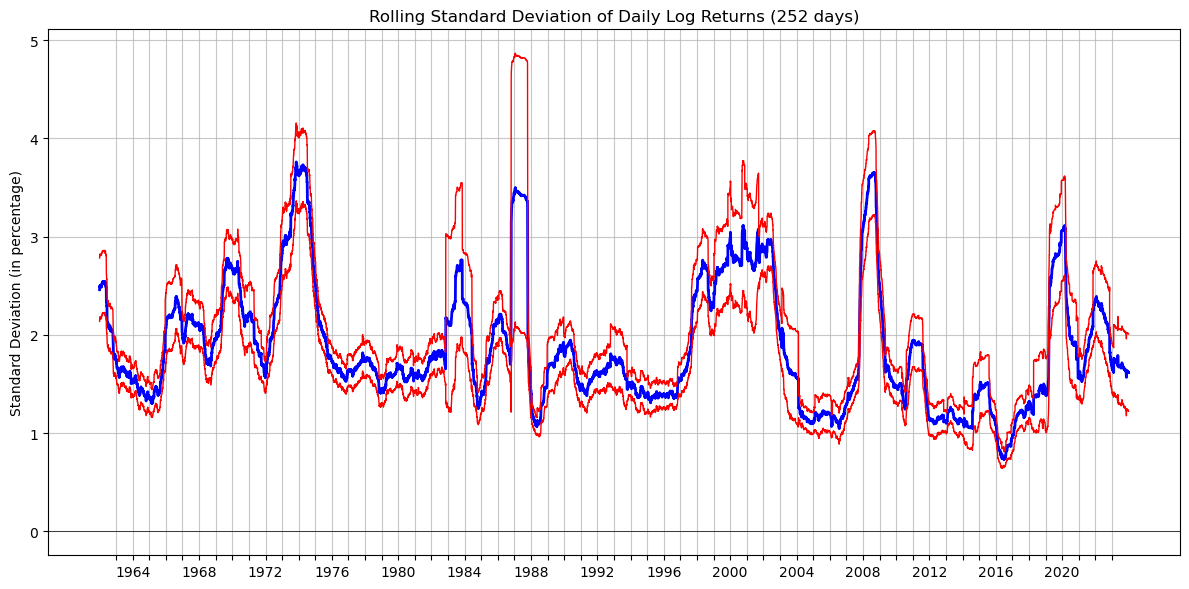

In [84]:
# TEST 1: 252 days rolling volatility plot

# Define rolling parameter
window = 252

# Compute rolling standard deviation and standard error
roll_std_252 = rt_daily.rolling(window=window).std(ddof=0)
roll_mu4 = rt_daily.rolling(window=window).apply(lambda x: np.mean(x**4), raw=True)
stderr = (1 / (2 * roll_std_252)) * np.sqrt(np.maximum(roll_mu4 - roll_std_252**4, 0)) / np.sqrt(window)

# Confidence interval upper and lower
roll_std_upper = roll_std_252 + 1.96 * stderr
roll_std_lower = roll_std_252 - 1.96 * stderr

# Define dataframe for rolling data
data2plot = pd.DataFrame({
    'Std': roll_std_252,
    'Lower.Bound': roll_std_upper,
    'Upper.Bound': roll_std_lower
}).dropna()


# Plot the rolling std
plt.figure(figsize=(12, 6))
plt.plot(data2plot.index, data2plot["Std"] * 100, color='blue', linestyle='-', linewidth=2)

# Plot confidence interval
plt.plot(data2plot.index, data2plot["Lower.Bound"] * 100, color='red', linestyle='-', linewidth=1)
plt.plot(data2plot.index, data2plot["Upper.Bound"] * 100, color='red', linestyle='-', linewidth=1)

# Format the graph
date_labels = pd.date_range(start=data2plot.index.min(), end=data2plot.index.max(), freq='YE-DEC')
formatted_labels = [f'{date.year}' if date.year % 4 == 0 else '' for date in date_labels]
plt.xticks(date_labels, formatted_labels, rotation=0)

# Mise en forme du graphique
plt.xlabel('')
plt.ylabel('Standard Deviation (in percentage)')
plt.title(f'Rolling Standard Deviation of Daily Log Returns ({window} days)')
plt.grid(True, linestyle='-', alpha=0.7)
plt.axhline(0, linestyle='-', color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

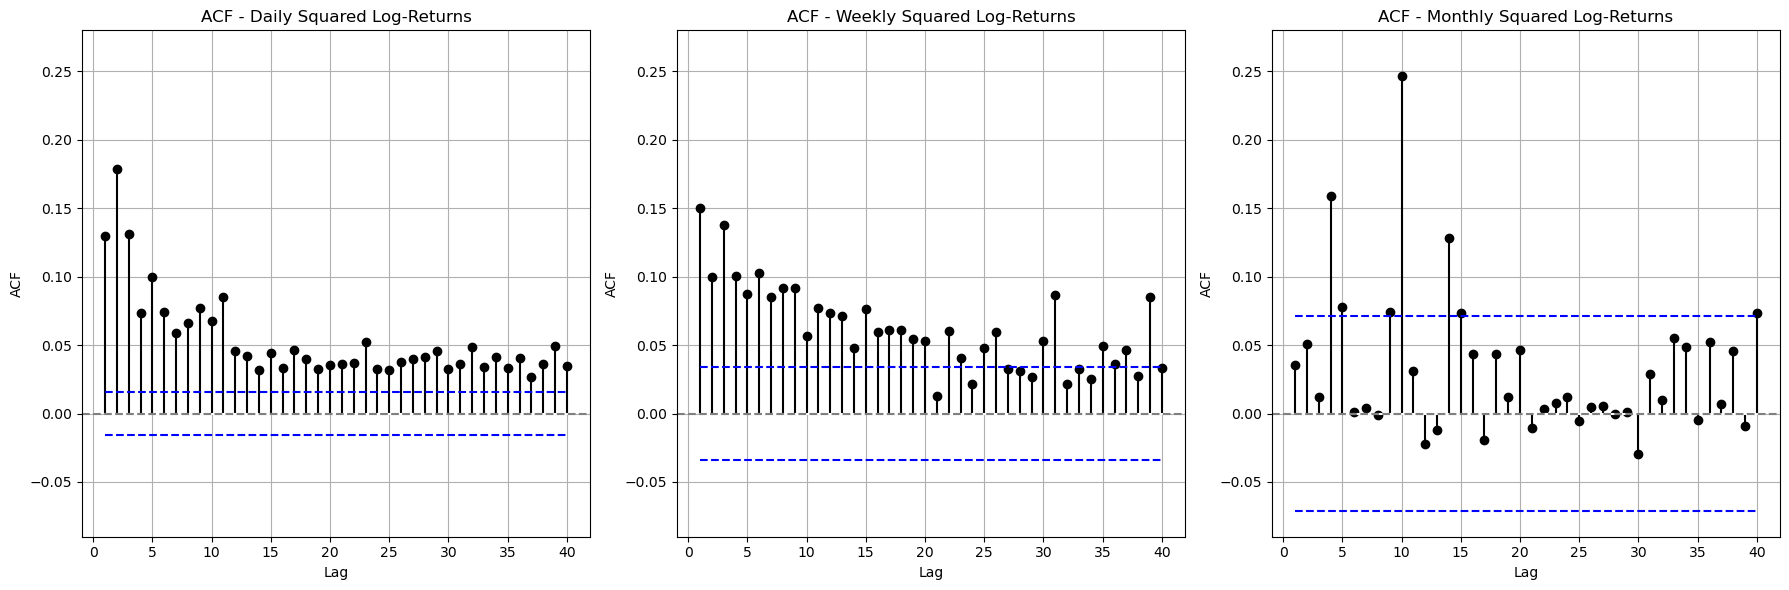

Autocorrelation function
-----
                Daily     Weekly   Monthly
Interval     0.015565   0.034192  0.071379
Violations  40.000000  30.000000  7.000000
-----
• Significant autocorrelation of daily squared returns at lags: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40
• Significant autocorrelation of weekly squared returns at lags: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 25, 26, 30, 31, 35, 36, 37, 39
• Significant autocorrelation of monthly squared returns at lags: 4, 5, 9, 10, 14, 15, 40


In [85]:
# TEST 2: ACF plotting of squared log returns

# Define dictionnary of squared log returns
rt_sqrd = {freq: np.power(value, 2) for freq, value in rt.items()}

# Define function setting
lags_sqrd = 40
valueint = 1.96

# Define the DataFrame structure
agg_acf_sqrd = {}

# Create a subplot to plot ACF
fig, axs = plt.subplots(1, len(rt_sqrd) - 1, figsize=(18, 6))  # len(rt) - 1 pour exclure "Annual"

# Plot and create data structure
for i, (freq, data) in enumerate(rt_sqrd.items()):
    if freq == "Annual":
        continue  

    # Compute ACF values
    acf_values = acf(data, nlags=lags_sqrd)
    confint = valueint / np.sqrt(len(data))
    confint_upper = np.full(lags_sqrd, confint)
    confint_lower = -np.full(lags_sqrd, confint)

    # Detect interval violation
    acf_lags_sqrd = acf_values[1:]
    violations = np.where((acf_lags_sqrd > confint) | (acf_lags_sqrd < -confint))[0] + 1
    n_viol = len(violations)
    violidx = ", ".join(map(str, violations)) if n_viol > 0 else None
    agg_acf_sqrd[freq] = [confint, n_viol, violidx]


    # Plot the result
    axs[i].stem(np.arange(1, lags_sqrd + 1), acf_values[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
    axs[i].axhline(y=0, color='gray', linestyle='--')
    axs[i].plot(np.arange(1, lags_sqrd + 1), confint_upper, color='blue', linestyle='dashed')
    axs[i].plot(np.arange(1, lags_sqrd + 1), confint_lower, color='blue', linestyle='dashed')
    axs[i].set_ylim(-0.09, 0.28)
    axs[i].set_title(f'ACF - {freq} Squared Log-Returns')
    axs[i].set_xlabel('Lag')
    axs[i].set_ylabel('ACF')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# Create a summary data frame
ACFT_SQ = pd.DataFrame({key: value[:-1] for key, value in agg_acf_sqrd.items() if value},index=['Interval', "Violations"])

# Print table and results for each frequency
print(f"Autocorrelation function\n-----\n{ACFT_SQ}\n-----")
for freq, (_, _, idx) in agg_acf_sqrd.items():
    print(f"• Significant autocorrelation of {freq.lower()} squared returns at lags: {idx}")

In [86]:
# TEST 3: Ljung-Box and Box-Pierce tests for autocorrelation of squared log returns

# Define the lag to test for
lag_lj_sqrd = 25
valueint = 1.96
LBBP_SQ = {}

# Compute LB and BP tests on daily, weekly, and monthly returns
for freq, series in rt_sqrd.items():
    if freq == "Annual":
        continue
    
    # Compute the Ljung-Box and Box-Pierce test
    lbbp_results = acorr_ljungbox(series, lags=np.arange(1, lag_lj_sqrd+1), boxpierce=True)

    # Compute ACF test and critical value for daily returns
    acf_val = acf(series, nlags=lag_lj_sqrd)
    act_confint = np.full(lag_lj_sqrd, valueint) / np.sqrt(len(series))
    acf_tstat_0 = (acf_val[1:] - 0) / np.sqrt(1 / len(series))
    crit_value_5_BP = stats.chi2.ppf(0.95, np.arange(1, lag_lj_sqrd+1))

    # Create a dataframe for each time series
    ar_summary = pd.DataFrame({
        "ACF": acf_val[1:],
        "ACF diam.": act_confint,
        "ACF t-test": acf_tstat_0,
        "LB stat": lbbp_results["lb_stat"],
        "LB pval": lbbp_results["lb_pvalue"],
        "BP stat": lbbp_results["bp_stat"],
        "BP pval": lbbp_results["bp_pvalue"],
        "Critical": crit_value_5_BP,
    }, index=np.arange(1, lag_lj_sqrd+1))
    ar_summary.index.name = "Lags"

    LBBP_SQ[freq] = ar_summary

# Print results
def describe_LB(x):
    return (
        f"Fail to reject the null hypothesis, no autocorrelation detected"
        if x > 0.05 else
        f"Reject the null hypothesis, autocorrelation detected"
    )

print(f"H0: No autocorrelation up to lag p\nH1: One autocorrelation or more up to lag p\n-----")

for freq, value in LBBP_SQ.items():
    print(f"{freq} log returns:")  
    print(f"• Lag 1 - Stat: {round(value.loc[1, "LB stat"], 5)} | p-value: {round(value.loc[1, "LB pval"], 5)} → {describe_LB(value.loc[1, "LB pval"])}")
    print(f"• Lag 5 - Stat: {round(value.loc[5, "LB stat"], 5)} | p-value: {round(value.loc[5, "LB pval"], 5)} → {describe_LB(value.loc[5, "LB pval"])}")
    print(f"• Lag 10 - Stat: {round(value.loc[10, "LB stat"], 5)} | p-value: {round(value.loc[10, "LB pval"], 5)} → {describe_LB(value.loc[10, "LB pval"])}\n-----")

print(f"ACF, Ljung-Box and Box-Pierc table:\n-----\n{LBBP_SQ["Daily"]}\n-----")

H0: No autocorrelation up to lag p
H1: One autocorrelation or more up to lag p
-----
Daily log returns:
• Lag 1 - Stat: 266.04674 | p-value: 0.0 → Reject the null hypothesis, autocorrelation detected
• Lag 5 - Stat: 1288.2771 | p-value: 0.0 → Reject the null hypothesis, autocorrelation detected
• Lag 10 - Stat: 1666.70254 | p-value: 0.0 → Reject the null hypothesis, autocorrelation detected
-----
Weekly log returns:
• Lag 1 - Stat: 73.88088 | p-value: 0.0 → Reject the null hypothesis, autocorrelation detected
• Lag 5 - Stat: 227.7345 | p-value: 0.0 → Reject the null hypothesis, autocorrelation detected
• Lag 10 - Stat: 352.19203 | p-value: 0.0 → Reject the null hypothesis, autocorrelation detected
-----
Monthly log returns:
• Lag 1 - Stat: 0.9471 | p-value: 0.33046 → Fail to reject the null hypothesis, no autocorrelation detected
• Lag 5 - Stat: 26.83144 | p-value: 6e-05 → Reject the null hypothesis, autocorrelation detected
• Lag 10 - Stat: 77.58762 | p-value: 0.0 → Reject the null hy

In [87]:
# TEST 4: GARCH model to test volatility clustering on daily log returns

# Compute rt_daily in percent to ease estimation convergence
rt_daily_pct = rt_daily * 100

# Compute the result of GARCH(1,1) model (captures most of the persisting volatility)
garch_spec = arch_model(rt_daily_pct, vol='Garch', p=1, q=1, dist='t', mean='Zero', rescale=False)
garch_fit = garch_spec.fit(disp=False)

# Extract GARCH results (omega / 100^2 to adjust for the scaling factor)
GARCH = pd.DataFrame({
    'Estimate': [garch_fit.params["omega"] / np.power(100,2), garch_fit.params["alpha[1]"], garch_fit.params["beta[1]"]], 
    'p-value': [garch_fit.pvalues["omega"], garch_fit.pvalues["alpha[1]"], garch_fit.pvalues["beta[1]"]], 
}, index=["omega", "alpha[1]", "beta[1]"])


# Printing GARCH results
def describe_garch(res):
    print("Estimates significance:")
     # Omega
    if res.loc["omega", "p-value"] < 0.05:
        print(f"• Omega (constant factor): is significant, confirming that a stable unconditional variance is present in the time series.")
    else:
        print(f"• Omega (constant factor): is not significant, indicating that most of the variance dynamics are explained by shock and memory effects")
    # Alpha
    if res.loc["alpha[1]", "p-value"] < 0.05:
        print(f"• Alpha (ARCH factor): is significant, indicating the effect of the previous period shock (squared returns) on today's volatility.")
    else:
        print(f"• Alpha (ARCH factor): is not significant, indicating the that the previous period shock (squared returns) do not have a significant impact on today's volatility.")
    # Beta
    if res.loc["beta[1]", "p-value"] < 0.05:
        print(f"• Beta (GARCH factor): is significant, indicating that volatility exhibits strong persistence and that shocks take time to decay.")
    else:
        print(f"• Beta (GARCH factor): is not significant, indicating that volatility doesn't exhibit strong persistence and that shocks decay fast.")
    
    print("-----\nGARCH interpretation:")

    # Volatility clustering intensity
    persistence = res.loc["alpha[1]", "Estimate"] + res.loc["beta[1]", "Estimate"]
    if persistence < 0.5:
        print(f"• Volatility is weakly persistent (alpha + beta = {persistence:.2f}), indicating low volatlity clustering.")
    elif persistence < 0.95:
        print(f"• Volatility is moderately persistent (alpha + beta = {persistence:.2f}), indicating moderate volatlity clustering.")
    else:
        print(f"• Volatility is highly persistent (alpha + beta = {persistence:.2f}), indicating strong volatlity clustering.")

    # Volatility clustering decomposition
    if res.loc["alpha[1]", "Estimate"] > res.loc["beta[1]", "Estimate"]:
        print("• Volatility clustering is mainly driven by recent shocks (alpha > beta), indicating the effect of the previous period shock.")
    else:
        print("• Volatility clustering is mainly driven by persistence of past shocks (beta > alpha), indicating the effect of volatility long-term memory.")



print(f"\n----- GARCH(1,1) Model Results -----\n\n{GARCH}\n-----")
describe_garch(GARCH)


----- GARCH(1,1) Model Results -----

          Estimate       p-value
omega     0.000003  5.437770e-04
alpha[1]  0.058261  8.340657e-10
beta[1]   0.934258  0.000000e+00
-----
Estimates significance:
• Omega (constant factor): is significant, confirming that a stable unconditional variance is present in the time series.
• Alpha (ARCH factor): is significant, indicating the effect of the previous period shock (squared returns) on today's volatility.
• Beta (GARCH factor): is significant, indicating that volatility exhibits strong persistence and that shocks take time to decay.
-----
GARCH interpretation:
• Volatility is highly persistent (alpha + beta = 0.99), indicating strong volatlity clustering.
• Volatility clustering is mainly driven by persistence of past shocks (beta > alpha), indicating the effect of volatility long-term memory.


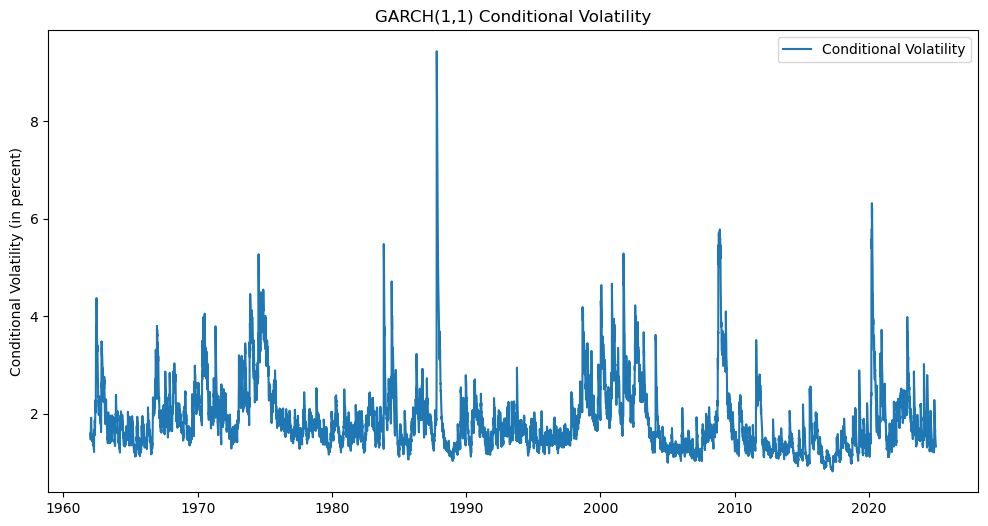

In [88]:
# TEST 5: Plot GARCH(1,1) conditional volatility

# Define implied condition volatility (in percent)
cond_volatility = garch_fit.conditional_volatility

# Plot conditional volatility
plt.figure(figsize=(12, 6))
plt.plot(garch_fit.conditional_volatility, label='Conditional Volatility')
plt.title('GARCH(1,1) Conditional Volatility')
plt.ylabel('Conditional Volatility (in percent)')
plt.legend()
plt.show()


#### Stylized Facts 8: Leverage effect

In [89]:
"""
Leverage effect says: loss in stock price -> increase in vol
"""

'\nLeverage effect says: loss in stock price -> increase in vol\n'

In [90]:
# Preliminary: retreive and transform VIX data

# Retreive VIX history on Yahoo Finance
VIX = yf.download("^VIX", start="1961-01-02", end="2024-12-31", auto_adjust=False)

# Convert the VIX DataFrame and extract closing price
VIX.set_index(pd.to_datetime(VIX.index))
VIX = VIX.sort_index()
VIX_daily = VIX["Adj Close"]["^VIX"]
VIX_daily.name = "VIX.d"

# Merge normal prices and VIX
Pt_daily_VIX = pd.merge(Pt_daily, VIX_daily, on='Date',how='outer').dropna()

Pt_daily_VIX

[*********************100%***********************]  1 of 1 completed


,Pt.d,VIX.d
Date,,
1990-01-02,6.854019,17.240000
1990-01-03,6.868857,18.190001
1990-01-04,6.861438,19.219999
1990-01-05,6.883694,20.110001
1990-01-08,6.942799,20.260000
...,...,...
2024-12-23,110.926964,16.780001
2024-12-24,112.082031,14.270000
2024-12-26,112.072083,14.730000


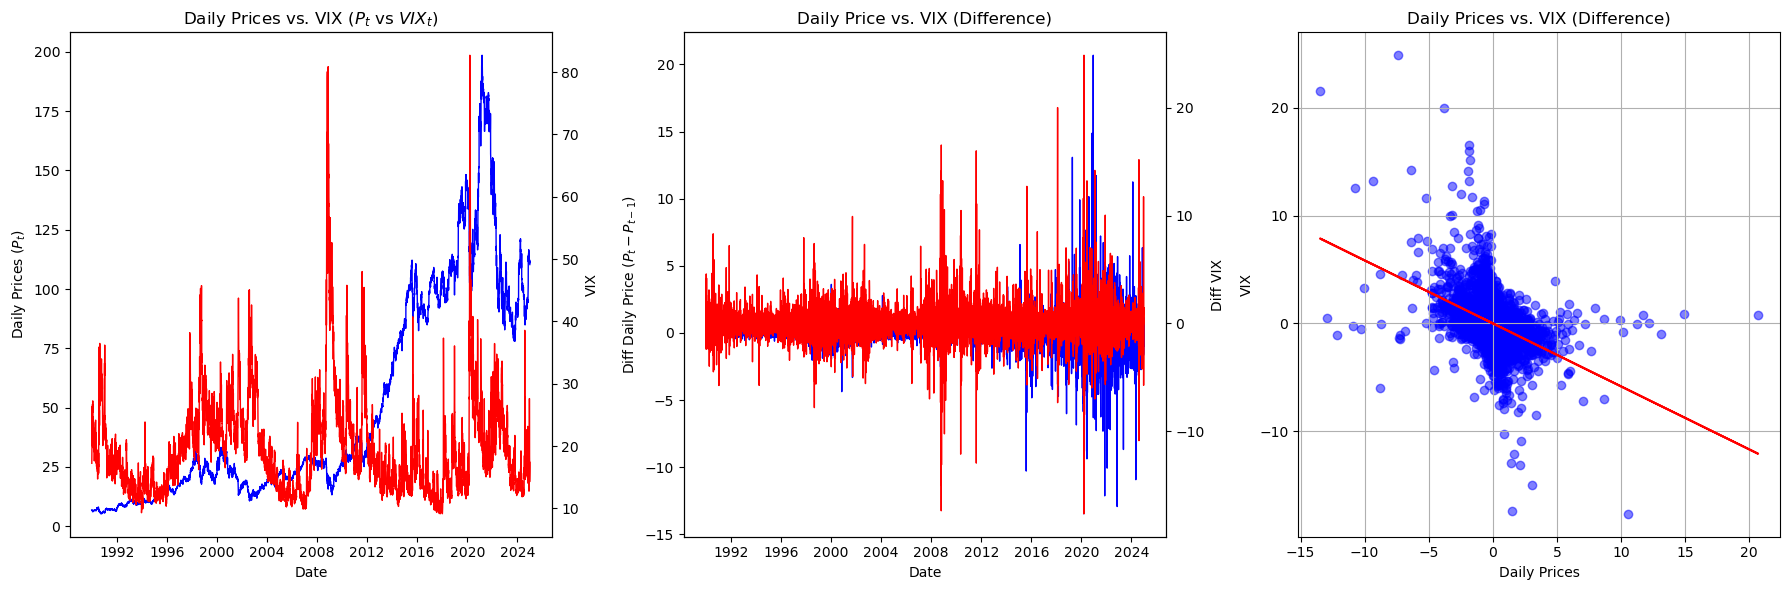

Linear Regression
-----
Intercept    0.006874
Slope       -0.584038
r-squared    0.163882
p-value      0.000000
dtype: float64
-----
The beta coefficient (-0.58) is  significantly different from 0, indicating a negative relation between prices and volatility
The R2 is equal to 0.1639, indicating that 16.39% of VIX variance is explained by the daily prices variance (according to the linear model)


In [91]:
# TEST 1: Plot price-volatility relation and linear regression

# Compute the absolute difference of prices and VIX
Pt_daily_VIX_change = Pt_daily_VIX.diff().dropna()

# Compute the linear regression
linreg = linregress(Pt_daily_VIX_change["Pt.d"], Pt_daily_VIX_change["VIX.d"])
slope = linreg.slope
intercept = linreg.intercept
regline = np.polyval([slope, intercept], Pt_daily_VIX_change['Pt.d'])

# Create a serie for the linear regression result
LR = pd.Series({
    "Intercept": intercept,
    "Slope": slope,
    "r-squared": np.power(linreg.rvalue, 2),
    "p-value": linreg.pvalue
})

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot price vs VIX
axs[0].plot(Pt_daily_VIX.index, Pt_daily_VIX['Pt.d'], label='Daily Prices', color='blue', lw=1)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Daily Prices ($P_t$)', color='black')
axs[0].set_title('Daily Prices vs. VIX ($P_t$ vs $VIX_t$)')
# Right axe
axs0_alt = axs[0].twinx()
axs0_alt.plot(Pt_daily_VIX.index, Pt_daily_VIX['VIX.d'], label='VIX',color='red', lw=1)
axs0_alt.set_ylabel('VIX', color='black')

# Plot price change vs VIX change
axs[1].plot(Pt_daily_VIX_change.index, Pt_daily_VIX_change['Pt.d'], label='Diff Daily Price', color='blue', lw=1)
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Diff Daily Price ($P_t - P_{t-1}$)', color='black')
axs[1].set_title('Daily Price vs. VIX (Difference)')
# Right axe
axs1_alt = axs[1].twinx()
axs1_alt.plot(Pt_daily_VIX_change.index, Pt_daily_VIX_change['VIX.d'], label='Diff VIX', color='red', lw=1)
axs1_alt.set_ylabel('Diff VIX', color='black')

# Plot scatter and regression line
axs[2].scatter(Pt_daily_VIX_change['Pt.d'], Pt_daily_VIX_change['VIX.d'], color='blue', marker='o', alpha=0.5)
axs[2].plot(Pt_daily_VIX_change['Pt.d'], regline, color='red', linewidth=1.5)
axs[2].set_xlabel('Daily Prices')
axs[2].set_ylabel('VIX')
axs[2].set_title('Daily Prices vs. VIX (Difference)')
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Print linear regression result
def describe_linreg(beta, pval, rsq):
    print(f"The beta coefficient ({round(beta, 2)}) is {'' if pval < 0.05 else 'not'} significantly different from 0, indicating a {'negative' if beta < 0 else 'positive'} relation between prices and volatility")
    print(f"The R2 is equal to {round(rsq, 4)}, indicating that {round(rsq * 100, 2)}% of VIX variance is explained by the daily prices variance (according to the linear model)")

print(f"Linear Regression\n-----\n{LR}\n-----")
describe_linreg(LR["Slope"], LR["p-value"], LR["r-squared"])

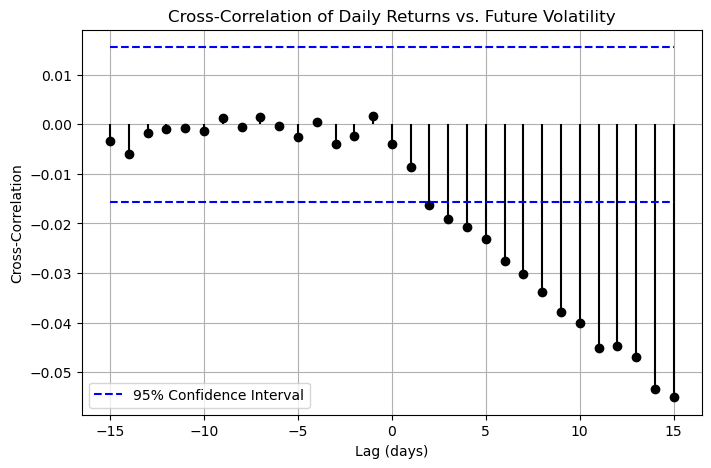

The cross-correlation shows evidence of leverage effect, negative returns tend to precede increased volatility.


In [92]:
# TEST 2: Cross correlation of log returns and future volatility

# Compute rolling volatility
window = 15
lag_cc = 15
roll_std_15 = rt_daily.rolling(window=window).std(ddof=0).dropna()

# Adjust daily log returns to account for the substract of the rolling window
rt_daily_adj15 = rt_daily[-len(roll_std_15):]

# Define the cross-correlation function
def ccf(x, y, lag_max=20):
    result = ss.correlate(y - np.mean(y), x - np.mean(x), method='direct') / (np.std(y) * np.std(x) * len(y))
    length = (len(result) - 1) // 2
    lo = length - lag_max
    hi = length + (lag_max + 1)
    return result[lo:hi]

# Compute the CC between daily log returns and future volatility
cross_corr = ccf(rt_daily_adj15, roll_std_15, lag_max=lag_cc)

# Define variables for plotting
lag_values = np.arange(-lag_cc, lag_cc + 1)
confin = 1.96 / np.sqrt(len(rt_daily_adj15))
confint_upper = np.full(len(lag_values), confin)
confint_lower = np.full(len(lag_values), -confin)

# Plot the cross-correlation
plt.figure(figsize=(8, 5))
plt.stem(lag_values, cross_corr, basefmt=" ", linefmt='black')
plt.plot(lag_values, confint_upper, color='blue', linestyle='dashed', label="95% Confidence Interval")
plt.plot(lag_values, confint_lower, color='blue', linestyle='dashed')
plt.xlabel('Lag (days)')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation of Daily Returns vs. Future Volatility')
plt.legend()
plt.grid(True)
plt.show()

if np.any(cross_corr < -confin):
    print("The cross-correlation shows evidence of leverage effect, negative returns tend to precede increased volatility.")
else:
    print("The cross-correlation doesn't show evidence of leverage effect, negative returns do not significantly precede increased volatility.")


In [93]:
# TEST 3: Granger causality test

# Create a series with only negative returns (adjusted for 15 period)
neg_rt_daily_adj15 = rt_daily_adj15.apply(lambda x: x if x < 0 else 0)

# Create a dataframe of daily log returns (adjusted) vs. 15 days rolling vol
neg_rt_daily_vol15 = pd.merge(roll_std_15, neg_rt_daily_adj15, on='Date',how='outer').dropna()
neg_rt_daily_vol15.columns = ['neg.rt.d.15', 'vol.d.15']

# Compute Granger result
lag_gc = 15
granger_result = grangercausalitytests(neg_rt_daily_vol15[["vol.d.15", "neg.rt.d.15"]], maxlag=lag_gc, verbose=False)

# Create Dataframe to summarize results
GC = pd.DataFrame(
    [{
            "F-Stat": granger_result[lag][0]['ssr_ftest'][0],
            "p-value": granger_result[lag][0]['ssr_ftest'][1],
            "Causality": granger_result[lag][0]['ssr_ftest'][1] < 0.05}
        for lag in range(1, lag_gc + 1)
    ], index= range(1, lag_gc + 1))
GC.index.name = "Lags"

# Print results
def describe_granger(res):
    siglags = res.index[res['Causality']].tolist()
    if not siglags:
        return "Fail to reject the null hypothesis, no evidence that negative returns cause volatility at any lag"
    else:
        return f"Reject the null hypothesis, negative returns cause volatility on {len(siglags)} lags. The effect occurs from {min(siglags)} to {max(siglags)} days (or more) after the observation"

print(f"H0: Past negative values of X do not contain any predictive information about Y\nH1: Past negative values of X contain useful information that helps predict Y\n-----\n{GC}\n-----")
print(describe_granger(GC))


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


H0: Past negative values of X do not contain any predictive information about Y
H1: Past negative values of X contain useful information that helps predict Y
-----
          F-Stat        p-value  Causality
Lags                                      
1     463.103432  2.850717e-101       True
2     210.706583   4.872622e-91       True
3     121.034149   1.667708e-77       True
4      79.661313   4.905594e-67       True
5      57.463317   1.882951e-59       True
6      40.892339   1.002931e-49       True
7      30.857413   9.347420e-43       True
8      25.091499   8.117480e-39       True
9      20.513183   9.013118e-35       True
10     16.769176   1.244065e-30       True
11     13.198863   1.915208e-25       True
12     10.524860   4.217598e-21       True
13     10.058001   1.855176e-21       True
14      9.466868   2.695155e-21       True
15      8.986949   3.067109e-21       True
-----
Reject the null hypothesis, negative returns cause volatility on 15 lags. The effect occurs from 1 

### Part II - Pricing Models

In [121]:
import pandas_datareader.data as pdr

##### Load data and transformation

In [123]:
FF = pdr.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1951-12-31', end="2024-12-31")[0]

FF.head(10)

/var/folders/z6/j_nqb41d7p71wfmbz0m97p200000gn/T/ipykernel_5046/763973589.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FF = pdr.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1951-12-31', end="2024-12-31")[0]
/var/folders/z6/j_nqb41d7p71wfmbz0m97p200000gn/T/ipykernel_5046/763973589.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FF = pdr.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1951-12-31', end="2024-12-31")[0]


,Mkt-RF,SMB,HML,RF
Date,,,,
1951-12,3.33,-2.24,-1.55,0.12
1952-01,1.45,-0.65,1.48,0.15
1952-02,-2.64,0.85,-0.62,0.12
1952-03,4.44,-2.97,2.23,0.11
1952-04,-4.97,0.49,-0.03,0.12
1952-05,3.20,-1.00,0.02,0.13
1952-06,3.84,-1.63,1.24,0.15
1952-07,0.91,-0.41,-0.32,0.15
1952-08,-0.77,1.15,0.09,0.15
